In [1]:
import sklearn
sklearn.__version__

'1.4.1.post1'

In [51]:
print(sklearn.__version__)

1.4.1.post1


In [2]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from scipy import stats, interpolate
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,TheilSenRegressor, Lasso,RANSACRegressor, HuberRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

import os
import tensorflow as tf
from tensorflow.keras import Model, models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Dense,MaxPooling1D,Flatten,Dropout,concatenate, Concatenate,GRU, concatenate, Input, LSTM, Bidirectional, LeakyReLU, BatchNormalization, ReLU
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2, l1_l2
import tensorflow.keras as keras
from grad_cam import grad_cam_regression
import warnings
warnings.filterwarnings(action='ignore')

In [75]:
def LOOCV(model,feature,data):
    predicted_list = []
    actual_list = []
    R_list = []

    for sample in samples:
        train = data[data['ID']!=sample]
        val = data[data['ID']==sample]

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(train[feature])
        x_val = scaler.transform(val[feature])
        train_ppgr = np.array(train[PPGR_4])
        val_ppgr = np.array(val[PPGR_4])

        print(f"Leave {sample} out validation start")

        model.fit(x_train,train_ppgr)

        pred_y = model.predict(x_val)
        predicted_list.append(pred_y.flatten())
        actual_list.append(val_ppgr)

        r, p = stats.pearsonr(val_ppgr, pred_y)
        R_list.append(r)

        print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")
        
        predicted_ls = [v for y in predicted_list for v in y.tolist()]
        actual_ls = [v for y in actual_list for v in y]
        r, p = stats.pearsonr(predicted_ls, actual_ls)
        print(f"So far, R is {np.round(r,3)}")
    return predicted_list, actual_list, R_list

    
def LOOCV_vis2(predicted_list,actual_list,model):
    plt.style.use(['default']) 
    predicted_ls = [v for y in predicted_list for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    abs_error = np.abs([predicted_ls[i] - actual_ls[i] for i in range(len(predicted_ls))])
    
    guideline = np.linspace(-500,800,10)
    plt.figure(figsize=(5,3))
    plt.scatter(y=predicted_ls,x=actual_ls,alpha=0.8,c=abs_error,cmap='coolwarm',s=7,vmin=0,vmax=650)#color='gray'
    cbar = plt.colorbar()
    cbar.set_label('Absolute error (mg/dl•h)', rotation=90)
    res = stats.pearsonr(predicted_ls, actual_ls)
    plt.plot(guideline,guideline,'--',lw=1,color='gray')

    plt.ylabel(f'Predicted PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlabel(f'Measured PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlim(np.min(actual_ls)-30,np.max(actual_ls)+30)
    #plt.ylim(-100,300)
    plt.ylim(-300,480)
    
    ymin, ymax = plt.gca().get_ylim()
    plt.text(np.min(actual_ls),ymin+(ymax-ymin)*9/10,f'R={np.round(res[0],3)}',fontsize=12)
    plt.text(np.min(actual_ls),ymin+(ymax-ymin)*8.5/10,'p=%.2e'%res[1],fontsize=10)
    if model[:11] == '_carbo_only': 
        plt.title(f'Carbohydrate single predictor LOOCV',fontsize=10)
        plt.savefig(f"../figure/main_cohort_model{model}.jpeg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    else: 
        plt.title(f'DNN model{model} LOOCV',fontsize=10)
        plt.savefig(f"../figure/main_cohort_DNN_model{model}.jpeg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    plt.show()

def Evaluation_vis(predicted,actual,model):
    plt.style.use(['default']) 
    abs_error = np.abs(predicted-actual)
    #error_group = ['Higher_than_actual' if predicted[i]-actual[i]>baseline_error_median_eval else 'Lower_than_actual' if predicted[i]-actual[i]<-baseline_error_median_eval else 'Within80' for i in range(len(predicted))]
    #print(error_group.count('Within80'))
    guideline = np.linspace(-500,800,10)
    plt.figure(figsize=(5,3))
    #plt.scatter(y=predicted,x=actual,alpha=0.8,c=abs_error,cmap='coolwarm',s=7,vmin=0,vmax=330)
    plt.scatter(y=predicted,x=actual,alpha=0.8,c=abs_error,cmap='coolwarm',s=7,vmin=0,vmax=650)#color='gray'
    cbar = plt.colorbar()
    cbar.set_label('Absolute error (mg/dl•h)', rotation=90)
    res = stats.pearsonr(predicted, actual)
    ci= res.confidence_interval(confidence_level=0.95)
    print(ci)
    plt.plot(guideline,guideline,'--',lw=1,color='gray')#e+baseline_error_median_eval
    #plt.plot(guideline,guideline-baseline_error_median_eval,'--',lw=1,color='gray')

    plt.ylabel(f'Predicted PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlabel(f'Measured PPGR ({model[-2]}-h iAUC, mg/dl•h)')
    plt.xlim(np.min(actual)-30,np.max(actual)+30)
    #plt.ylim(-50,200)
    plt.ylim(-300,480)
    
    ymin, ymax = plt.gca().get_ylim()
    plt.text(np.min(actual),ymin+(ymax-ymin)*9/10,f'R={np.round(res[0],3)}',fontsize=12)
    plt.text(np.min(actual),ymin+(ymax-ymin)*8.5/10,'p=%.2e'%res[1],fontsize=10)
    #plt.text(-120,np.mean(predicted),error_group.count('Higher_than_actual'),fontsize=10,weight="bold")
    #plt.text(20,np.mean(predicted),error_group.count('Within80'),fontsize=10,weight="bold")
    #plt.text(250,np.mean(predicted),error_group.count('Lower_than_actual'),fontsize=10,weight="bold")
    if model[:11] == '_carbo_only': 
        plt.title(f'Carbohydrate single predictor on evaluation cohort',fontsize=10)
        plt.savefig(f"../figure/evaluation_cohort_model{model}.jpeg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    else: 
        plt.title(f'DNN model{model} on evaluation cohort',fontsize=10)
        plt.savefig(f"../figure/evaluation_cohort_DNN_model{model}.jpeg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    plt.show()

# Data import

In [5]:
PPGR_meal_merged = pd.read_csv('../data/PPGR_meal_merged_cont2.csv',index_col=0)

CGM_post120_col = list(PPGR_meal_merged.columns[71:96])
CGM_post240_col = list(PPGR_meal_merged.columns[71:120])

PPGR_meal_merged[CGM_post240_col] = PPGR_meal_merged.loc[:,CGM_post240_col].interpolate(axis=1)
G0 = PPGR_meal_merged['p_000']

cgm_cols = list(PPGR_meal_merged.columns[71:120])

iAUC_2h = [0]*len(PPGR_meal_merged)
for i in range(1,25):
    Gi = PPGR_meal_merged[CGM_post120_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post120_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_2h+=Si*5
    
iAUC_4h = [0]*len(PPGR_meal_merged)
for i in range(1,49):
    Gi = PPGR_meal_merged[CGM_post240_col[i]]
    Gi_1 = PPGR_meal_merged[CGM_post240_col[i-1]]
    Si = ((Gi-G0)+(Gi_1-G0))/2
    iAUC_4h+=Si*5
    
    
PPGR_meal_merged['PPGR_u2'] = iAUC_2h/60
PPGR_meal_merged['PPGR_u4'] = iAUC_4h/60

In [6]:
PPGR_meal_merged_filt = PPGR_meal_merged.dropna(subset=['meal_m1'],axis=0)
#PPGR_meal_merged_filt = PPGR_meal_merged_filt[(PPGR_meal_merged_filt['meal_m1']>=-1440)] # Invalid meal record
PPGR_meal_merged_filt = PPGR_meal_merged_filt[(PPGR_meal_merged['Energy(kcal)']<2000) & (PPGR_meal_merged['Carb(g)']<250)]
PPGR_meal_merged_filt['Carb_root'] = PPGR_meal_merged_filt['Carb(g)']**(1/2)
PPGR_meal_merged_filt['Protein_root'] = PPGR_meal_merged_filt['Protein(g)']**(1/2)
PPGR_meal_merged_filt['Fat_root'] = PPGR_meal_merged_filt['Fat(g)']**(1/2)
PPGR_meal_merged_filt['Carb_pro'] = PPGR_meal_merged_filt['Carb(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Protein_pro'] = PPGR_meal_merged_filt['Protein(g)']*4 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100
PPGR_meal_merged_filt['Fat_pro'] = PPGR_meal_merged_filt['Fat(g)']*9 / (PPGR_meal_merged_filt['Carb(g)']*4+PPGR_meal_merged_filt['Protein(g)']*4+PPGR_meal_merged_filt['Fat(g)']*9) * 100

OTU_data = pd.read_csv('../data/T2D_KBSMC_otu_norm.csv',index_col=0)
#OTU_data = OTU_data.loc[:,list(np.sum(OTU_data>0) > len(OTU_data)*0.2)]
OTU_data_bc = pd.DataFrame(stats.boxcox(OTU_data,lmbda=0.25),columns=OTU_data.columns,index=OTU_data.index)
med_data = pd.read_excel('../data/CGM Nutrition_CRF_Medication.xlsx')
clinical_data = pd.read_excel('../data/CGM Nutrition_CRF_20230808_추가Lab.xlsx')

CGM_pre240_col = list(PPGR_meal_merged_filt.columns[23:72])
CGM_pre120_col = list(PPGR_meal_merged_filt.columns[47:72]) #19
CGM_pre60_col = list(PPGR_meal_merged_filt.columns[59:72]) #13
CGM_pre30_col = list(PPGR_meal_merged_filt.columns[65:72]) #7
CGM_post120_col = list(PPGR_meal_merged_filt.columns[71:96])
CGM_post240_col = list(PPGR_meal_merged_filt.columns[71:120])
        
PPGR_data =  PPGR_meal_merged_filt.dropna(subset=['PPGR_u2','PPGR_u4']+CGM_pre30_col,axis=0)
        
PPGR = 'PPGR_u2'
PPGR_4 = 'PPGR_u4'
meal_composition = ['Carb_root','Protein(g)','Fat(g)','Energy(kcal)','Fiber(g)','Carb_pro','Protein_pro','Fat_pro']
meal_context = ['meal_m1','prot_b6h','Time']
cli_col = ['Age','DM_Duration','BMI','HbA1c','SBP','DBP','HDL','LDL','AST(IU/L)','ALT(IU/L)'] #cli_col = ['Age','DM_Duration','BMI','Weight(kg)','Waist_Circumference(cm)','SBP','DBP','FBS','HbA1c','Total_chol','HDL','LDL','MDRD_eGFR','C-peptide_index','HR(bpm)','AST(IU/L)','ALT(IU/L)']
med_col = ['Basal_Ins_Dose_Unit','MFM_Dose_Total','SU_Dose_Total','DPP4i_Dose_Total','SGLT2i_Dose_Total'] 


#microbiome_col = list(pd.read_csv('../features/optimal_microbiome_features5.csv')['feature'])
f=pd.read_csv('../features/filter_p0.05_367.csv')
microbiome_col = list(f.loc[:,'feature'])


full_data = pd.merge(PPGR_data[['ID','Dname',PPGR,PPGR_4,'Carb(g)','Meal']+CGM_pre240_col+CGM_post240_col+meal_composition+meal_context],OTU_data_bc[microbiome_col],left_on='ID',right_index=True)
full_data = full_data.T.drop_duplicates().T
full_data = pd.merge(full_data,med_data,how='left',on='ID')
full_data = pd.merge(full_data,clinical_data,how='left',on='ID')
full_data[PPGR] = full_data[PPGR].astype(float)
full_data[PPGR_4] = full_data[PPGR_4].astype(float)

samples = list(full_data['ID'].unique())

full_data

ID                                              Dname     PPGR_u2  \
0    R01                                                 사과  114.625000   
1    R01                                         과일샐러드귀리흰우유   26.666667   
2    R01  고사리나물더덕구이도토리묵무침두부된장국땅콩조림무말랭이무침배추김치숙주나물시금치나물쌀밥오...  141.750000   
3    R01                                            라면사과회냉면  208.458333   
4    R01                                     계란:전란:삶은것국밥깍두기  168.083333   
..   ...                                                ...         ...   
906  R50                                              쇠고기덮밥   60.583333   
907  R50                                     상추소고기 구이(등심)쌀밥   24.458333   
908  R50                                  감자채볶음고추멸치볶음쌀밥열무김치   -4.875000   
909  R50                                              장어매운탕  -40.250000   
910  R50                                        복숭아:백도열무비빔밥   32.500000   

        PPGR_u4   Carb(g) Meal  m_240  m_235  m_230  m_225  ...   TG HDL LDL  \
0    244.666667      5.75    5    NaN    NaN    NaN    NaN  ...  315  32  44   
1    -24.791667    60.295    1  147.0  147.0  145.0  143.0  ...  315  32  44   
2    217.750000  136.5433    2  158.0  163.0  169.0  177.0  ...  315  32  44   
3    414.458333   175.816    3  137.0  136.0  135.0  134.0  ...  315  32  44   
4    193.666667     84.41    1  112.0  112.0  113.0  114.0  ...  315  32  44   
..          ...       ...  ...    ...    ...    ...    ...  ...  ...  ..  ..   
906  169.875000    78.797    2  267.0  270.0  271.0  272.0  ...  155  45  68   
907  116.250000     54.26    3  192.0  197.0  201.0  205.0  ...  155  45  68   
908  217.458333   73.6332    1  142.0  143.0  143.0  144.0  ...  155  45  68   
909  -61.000000  38.04943    2  173.0  181.0  191.0  204.0  ...  155  45  68   
910   90.250000   75.3915    3  187.0  187.0  188.0  190.0  ...  155  45  68   

    MDRD_eGFR C_pep C-peptide_index HOMA IR (C-peptide) HR(bpm) AST(IU/L)  \
0        86.1   1.7        4.612802            0.192700    91.5        24   
1        86.1   1.7        4.612802            0.192700    91.5        24   
2        86.1   1.7        4.612802            0.192700    91.5        24   
3        86.1   1.7        4.612802            0.192700    91.5        24   
4        86.1   1.7        4.612802            0.192700    91.5        24   
..        ...   ...             ...                 ...     ...       ...   
906     107.7   1.2        5.432546            0.163623    94.0        19   
907     107.7   1.2        5.432546            0.163623    94.0        19   
908     107.7   1.2        5.432546            0.163623    94.0        19   
909     107.7   1.2        5.432546            0.163623    94.0        19   
910     107.7   1.2        5.432546            0.163623    94.0        19   

    ALT(IU/L)  
0          39  
1          39  
2          39  
3          39  
4          39  
..        ...  
906        21  
907        21  
908        21  
909        21  
910        21  

[911 rows x 210 columns]

In [7]:
evaluation_data = pd.read_csv('../data/validation/PPGR_meal_merged_validation.csv',index_col=0)
evaluation_data

ID     PPGR_u2     PPGR_u4  Carb(g)  Meal  m_240  m_235  m_230  \
0     C0001  -37.500000   10.458333    10.00   5.0  130.0  128.0  129.0   
1     C0001  -38.583333 -135.500000    77.00   3.0  179.0  175.0  167.0   
2     C0001  121.250000  177.416667    50.45   1.0   84.0   82.0   78.0   
3     C0001  103.333333  368.458333    97.08   2.0   99.0  103.0  102.0   
4     C0001   64.458333  195.875000     3.66   3.0  246.0  253.0  253.0   
...     ...         ...         ...      ...   ...    ...    ...    ...   
1243  C0051   35.291667   49.250000    83.15   1.0  122.0  125.0  128.0   
1244  C0051   80.750000  154.000000    72.79   2.0  130.0  130.0  140.0   
1245  C0051  -30.875000  -93.125000    14.10   3.0  201.0  198.0  197.0   
1246  C0051   54.125000  112.833333    21.94   5.0  169.0  175.0  174.0   
1247  C0051  118.666667  282.666667    60.45   1.0  102.0   99.0   96.0   

      m_225  m_220  ...  \
0     126.0  123.0  ...   
1     160.0  159.0  ...   
2      75.0   73.0  ...   
3      99.0   98.0  ...   
4     255.0  257.0  ...   
...     ...    ...  ...   
1243  124.0  124.0  ...   
1244  148.0  151.0  ...   
1245  194.0  191.0  ...   
1246  169.0  166.0  ...   
1247   94.0   94.0  ...   

      Bacteria;Fusobacteria;Fusobacteria_c;Fusobacteriales;Fusobacteriaceae;Fusobacterium;Fusobacterium_necrogenes_group  \
0                                                  -4.0                                                                    
1                                                  -4.0                                                                    
2                                                  -4.0                                                                    
3                                                  -4.0                                                                    
4                                                  -4.0                                                                    
...                                                 ...                                                                    
1243                                               -4.0                                                                    
1244                                               -4.0                                                                    
1245                                               -4.0                                                                    
1246                                               -4.0                                                                    
1247                                               -4.0                                                                    

      Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Coriobacteriaceae;Slackia;Slackia_isoflavoniconvertens  \
0                                                  -4.0                                                                
1                                                  -4.0                                                                
2                                                  -4.0                                                                
3                                                  -4.0                                                                
4                                                  -4.0                                                                
...                                                 ...                                                                
1243                                               -4.0                                                                
1244                                               -4.0                                                                
1245                                               -4.0                                                                
1246                                               -4.0                                       

# Feature represnetation

In [8]:
def CGM_representation(CGM_input,conv_units=6, lstm_units=8):
    conv = Conv1D(filters=conv_units,kernel_size=2,strides=1,padding='same',name='CGM_conv')(CGM_input)
    batchnorm = BatchNormalization()(conv)
    leakyReLU = LeakyReLU(alpha=0.05)(batchnorm)
    lstm = LSTM(lstm_units, return_sequences=True,name='CGM_lstm')(leakyReLU)
    flat = Flatten()(lstm)
    return flat

def clinical_representation(clinical_input,clinical_units=10):
    drop1 = Dropout(0.3)(clinical_input)                                # best dropout 0.5
    dense_layer = Dense(clinical_units,name='clinical_FC')(drop1)       # best node 10
    batchnorm = BatchNormalization()(dense_layer)
    relu = ReLU()(batchnorm)
    drop2 = Dropout(0.5)(relu)
    return drop2

def microbiome_representation(microbiome_input, microbiome_units=20):
    drop1 = Dropout(0.3)(microbiome_input)                         # best dropout 0.5
    dense_layer = Dense(microbiome_units,name='microbiome_FC',kernel_regularizer=l1_l2(l1=1e-4, l2=0.001), bias_regularizer=l1_l2(l1=1e-4, l2=0.001))(drop1) # best node 20
    batchnorm = BatchNormalization()(dense_layer) 
    relu = ReLU()(batchnorm)
    drop2 = Dropout(0.5)(relu)                                   # best dropout 0.5
    return drop2

def medication_representation(medication_input, medication_units=7):
    drop1 = Dropout(0.3)(medication_input)  
    dense_layer = Dense(medication_units, name='medication_FC')(drop1) # best node 7
    batchnorm = BatchNormalization()(dense_layer)
    relu = ReLU()(batchnorm)
    drop2 = Dropout(0.5)(relu)                                   # best dropout 0.5
    return drop2

def fusion_regressor(concatenated_features, regression_units=50, dropout_rate=0.5):
    dense_layer = Dense(regression_units, kernel_regularizer=l1_l2(l1=1e-6, l2=0.001), bias_regularizer=l1_l2(l1=1e-6, l2=0.001))(concatenated_features)                     # best node 40
    batchnorm = BatchNormalization()(dense_layer)
    relu = ReLU()(batchnorm)
    drop = Dropout(dropout_rate)(relu)
    
    output_layer = Dense(1)(drop)
    return output_layer

In [9]:
mae = MeanAbsoluteError()
mse = MeanSquaredError()

# Carbohydrate only predictor (linear regression)

In [68]:
carbohydrate_only_predictor = LinearRegression()

carbo_only_predicted, actual, carbo_onlyR_list = LOOCV(carbohydrate_only_predictor,['Carb_root'],full_data)

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.601
So far, R is 0.601
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.567
So far, R is 0.568
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.389
So far, R is 0.517
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.272
So far, R is 0.461
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.48
So far, R is 0.387
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.599
So far, R is 0.403
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.267
So far, R is 0.394
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.42
So far, R is 0.396
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.258
So far, R is 0.379
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.557
So far, R i

In [69]:
predicted_ls = [v for y in carbo_only_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]
abs_error = np.abs([predicted_ls[i] - actual_ls[i] for i in range(len(predicted_ls))])
baseline_error_median_main = np.quantile(abs_error,0.5)
baseline_error_median_main

117.62647461691722

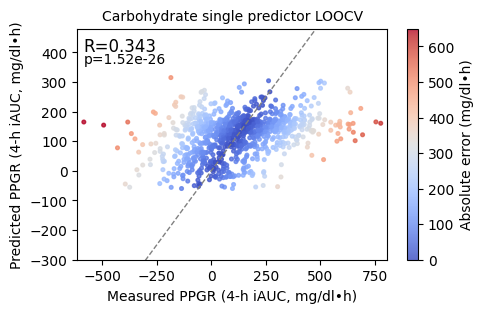

In [72]:
LOOCV_vis2(carbo_only_predicted,actual,'_carbo_only 4h')

In [73]:
predicted_ls = [v for y in carbo_only_predicted for v in y.tolist()]
actual_ls = [v for y in actual for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 183.06019412515053
MAE: 143.33186822800337


## Evaluation

The evaluation PCC is 0.348
ConfidenceInterval(low=0.29855207434311026, high=0.3961078464005302)


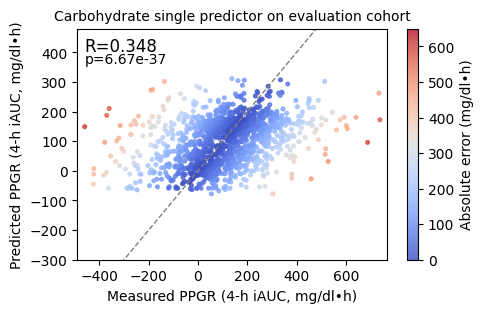

RMSE: 157.45108112068914
MAE: 120.351782291028


In [76]:
scaler = MinMaxScaler()
carbohydrate_only_predictor = LinearRegression()

x_train = full_data[['Carb_root']]
x_val = evaluation_data[['Carb_root']]
train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

carbohydrate_only_predictor.fit(x_train,train_ppgr)

pred_y = carbohydrate_only_predictor.predict(x_val)
r, p = stats.pearsonr(val_ppgr, pred_y)

print(f"The evaluation PCC is {np.round(r,3)}")

abs_error = np.abs([pred_y[i] - val_ppgr[i] for i in range(len(pred_y))])
baseline_error_median_eval = np.quantile(abs_error,0.5)

Evaluation_vis(pred_y,val_ppgr,'_carbo_only 4h')

print('RMSE:',mse(pred_y,val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y,val_ppgr).numpy())

# Model 1 : Meal composition

In [17]:
def Model1():
    random.seed(2)
    np.random.seed(2)
    tf.random.set_seed(2)

    input_layer_meal_composition = Input(shape=(8,), name='Meal composition')

    output = fusion_regressor(input_layer_meal_composition,20,0.5)  # best regression unit 20

    model = Model(inputs=input_layer_meal_composition, outputs=output)

    learning_rate = 0.005
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='mse')

    return model

In [77]:
data = full_data

model1_predicted = []
actual_list = []
model1_R_list = []

for sample in samples:
    print(f"Leave {sample} out validation start")
    model1 = Model1()
    
    train = data[data['ID']!=sample]
    val = data[data['ID']==sample]

    meal_composition_scaler = MinMaxScaler()
    x_train_meal_composition = meal_composition_scaler.fit_transform(train[meal_composition])
    x_val_meal_composition = meal_composition_scaler.transform(val[meal_composition])
    
    train_ppgr = np.array(train[PPGR_4])
    val_ppgr = np.array(val[PPGR_4])

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../main_LOOCV/model1_{sample}_best_model.h5',monitor='loss',save_best_only=True)
    model1.fit(x_train_meal_composition,train_ppgr,epochs=40,batch_size=32,verbose=0,callbacks=[checkpoint]) # best epoch 70
    
    pred_y = model1.predict(x_val_meal_composition,verbose=0)
    model1_predicted.append(pred_y.flatten())
    actual_list.append(val_ppgr)

    r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
    model1_R_list.append(r)
    print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")
    
    predicted_ls = [v for y in model1_predicted for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    r, p = stats.pearsonr(predicted_ls, actual_ls)
    print(f"So far, R is {np.round(r,3)}")

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.617
So far, R is 0.617
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.584
So far, R is 0.592
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.369
So far, R is 0.518
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.251
So far, R is 0.45
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.438
So far, R is 0.333
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.588
So far, R is 0.358
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.434
So far, R is 0.362
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.412
So far, R is 0.368
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.187
So far, R is 0.348
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.52
So far, R i

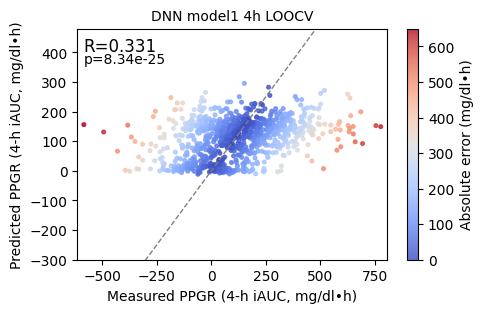

In [78]:
LOOCV_vis2(model1_predicted,actual_list,'1 4h')

In [79]:
predicted_ls = [v for y in model1_predicted for v in y.tolist()]
actual_ls = [v for y in actual_list for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 184.00983434648674
MAE: 143.80670031125496


## Evaluation

The evaluation PCC is 0.344
ConfidenceInterval(low=0.29397696106002524, high=0.3918710435117869)


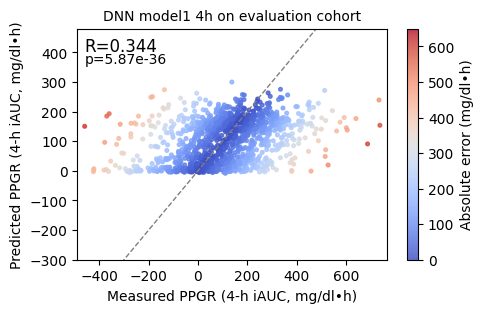

RMSE: 157.14876945798932
MAE: 120.00102243948189


In [80]:
model1 = Model1()

meal_composition_scaler = MinMaxScaler()
x_train_meal_composition = meal_composition_scaler.fit_transform(full_data[meal_composition])
x_val_meal_composition = meal_composition_scaler.transform(evaluation_data[meal_composition])

train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../evaluation/model1_best_model.h5',monitor='loss',save_best_only=True)
model1.fit(x_train_meal_composition,train_ppgr,epochs=40,batch_size=32,verbose=0,callbacks=[checkpoint]) # best epoch 40

pred_y = model1.predict(x_val_meal_composition,verbose=0)

r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
print(f"The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y.flatten(),val_ppgr,'1 4h')

print('RMSE:',mse(pred_y.flatten(),val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y.flatten(),val_ppgr).numpy())

# Model 2 : Meal composition + Meal context

In [26]:
def Model2():
    random.seed(2)
    np.random.seed(2)
    tf.random.set_seed(2)

    input_layer_meal_comp = Input(shape=(8,), name='Meal_composition')
    input_layer_meal_cont = Input(shape=(3,), name='Meal_context')

    concat = concatenate([input_layer_meal_comp,input_layer_meal_cont])
    output = fusion_regressor(concat,10,0.5)

    model = Model(inputs=[input_layer_meal_comp,input_layer_meal_cont],outputs=output)
    
    learning_rate = 0.005
    model.compile(optimizer = Adam(learning_rate=learning_rate),loss='mse')

    return model

In [81]:
data = full_data

model2_predicted = []
actual_list = []
model2_R_list = []
for sample in samples:
    print(f"Leave {sample} out validation start")
    model2 = Model2()
    
    train = data[data['ID']!=sample]
    val = data[data['ID']==sample]

    meal_composition_scaler = MinMaxScaler()
    x_train_meal_composition = meal_composition_scaler.fit_transform(train[meal_composition])
    x_val_meal_composition = meal_composition_scaler.transform(val[meal_composition])
    
    meal_context_scaler = MinMaxScaler()
    x_train_meal_context = meal_context_scaler.fit_transform(train[meal_context])
    x_val_meal_context = meal_context_scaler.transform(val[meal_context])
    
    train_ppgr = np.array(train[PPGR_4])
    val_ppgr = np.array(val[PPGR_4])

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../main_LOOCV/model2_{sample}_best_model.h5',monitor='loss',save_best_only=True)
    model2.fit([x_train_meal_composition,x_train_meal_context],train_ppgr,epochs=60,batch_size=32,verbose=0,callbacks=[checkpoint]) # best epoch 70

    pred_y = model2.predict([x_val_meal_composition,x_val_meal_context],verbose=0)
    model2_predicted.append(pred_y.flatten())
    actual_list.append(val_ppgr)

    r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
    model2_R_list.append(r)
    print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")
    
    predicted_ls = [v for y in model2_predicted for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    r, p = stats.pearsonr(predicted_ls, actual_ls)
    print(f"So far, R is {np.round(r,3)}")

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.452
So far, R is 0.452
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.702
So far, R is 0.636
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.673
So far, R is 0.611
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.419
So far, R is 0.564
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.738
So far, R is 0.563
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.534
So far, R is 0.556
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.451
So far, R is 0.549
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.369
So far, R is 0.536
Leave R09 out validation start
Leave R09 out validation is done. The PCC is -0.316
So far, R is 0.492
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.442
So far, 

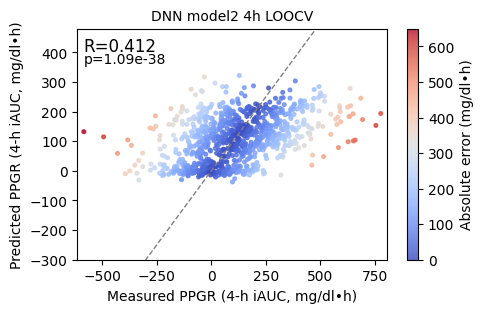

In [82]:
LOOCV_vis2(model2_predicted,actual_list,'2 4h')

In [83]:
predicted_ls = [v for y in model2_predicted for v in y.tolist()]
actual_ls = [v for y in actual_list for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 177.8402886293018
MAE: 140.52244549368137


## Evaluation

The evaluation PCC is 0.349
ConfidenceInterval(low=0.29890782433178226, high=0.3964371161984345)


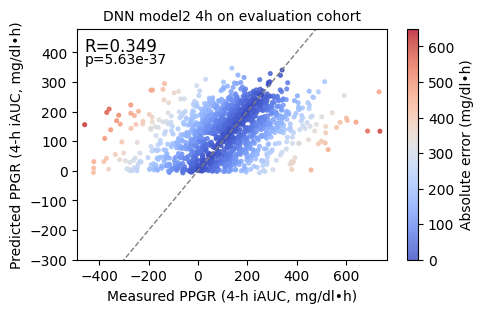

RMSE: 158.2505418769161
MAE: 120.34327431144112


In [84]:
model2 = Model2()

meal_composition_scaler = MinMaxScaler()
x_train_meal_composition = meal_composition_scaler.fit_transform(full_data[meal_composition])
x_val_meal_composition = meal_composition_scaler.transform(evaluation_data[meal_composition])

meal_context_scaler = MinMaxScaler()
x_train_meal_context = meal_context_scaler.fit_transform(full_data[meal_context])
x_val_meal_context = meal_context_scaler.transform(evaluation_data[meal_context])

train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../evaluation/model2_best_model.h5',monitor='loss',save_best_only=True)
model2.fit([x_train_meal_composition,x_train_meal_context],train_ppgr,epochs=50,batch_size=32,verbose=0,callbacks=[checkpoint]) # best epoch 50

pred_y = model2.predict([x_val_meal_composition,x_val_meal_context],verbose=0)

r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
print(f"The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y.flatten(),val_ppgr,'2 4h')

print('RMSE:',mse(pred_y.flatten(),val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y.flatten(),val_ppgr).numpy())

# Model 3 : Meal composition + Meal context + CGM

In [34]:
def Model3():
    random.seed(2)
    np.random.seed(2)
    tf.random.set_seed(2)

    input_layer_cgm = Input(shape=(7, 1), name='CGM')
    input_layer_meal_composition = Input(shape=(8,), name='Meal composition')
    input_layer_meal_context = Input(shape=(3,), name='Meal context')

    CGM_features = CGM_representation(input_layer_cgm,6,8) 
    concat = concatenate([CGM_features,input_layer_meal_composition,input_layer_meal_context])
    output = fusion_regressor(concat,10,0.5)

    model = Model(inputs=[input_layer_cgm,input_layer_meal_composition,input_layer_meal_context], outputs=output)

    learning_rate = 0.005
    model.compile(optimizer = Adam(learning_rate=learning_rate),loss='mse')
    
    return model

In [85]:
data = full_data

model3_predicted = []
actual_list = []
model3_R_list = []

for sample in samples:
    
    print(f"Leave {sample} out validation start")
    model3 = Model3()
    
    train = data[data['ID']!=sample]
    val = data[data['ID']==sample]
    
    cgm_mean = train[CGM_pre30_col].values.mean()
    cgm_std = train[CGM_pre30_col].values.std()
    x_train_cgm = np.array((train[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    x_val_cgm = np.array((val[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    
    meal_composition_scaler = MinMaxScaler()
    x_train_meal_composition = meal_composition_scaler.fit_transform(train[meal_composition])
    x_val_meal_composition = meal_composition_scaler.transform(val[meal_composition])
    
    meal_context_scaler = MinMaxScaler()
    x_train_meal_context = meal_context_scaler.fit_transform(train[meal_context])
    x_val_meal_context = meal_context_scaler.transform(val[meal_context])
        
    train_ppgr = np.array(train[PPGR_4])
    val_ppgr= np.array(val[PPGR_4])
        
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../main_LOOCV/model3_{sample}_best_model.h5',monitor='loss',save_best_only=True)
    model3.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context],train_ppgr,epochs=70,batch_size=32,verbose=0,callbacks=[checkpoint])

    pred_y = model3.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context],verbose=0)
    model3_predicted.append(pred_y.flatten())
    actual_list.append(val_ppgr)

    r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
    model3_R_list.append(r)
    print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")
    
    predicted_ls = [v for y in model3_predicted for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    r, p = stats.pearsonr(predicted_ls, actual_ls)
    print(f"So far, R is {np.round(r,3)}")

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.728
So far, R is 0.728
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.83
So far, R is 0.802
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.812
So far, R is 0.753
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.905
So far, R is 0.782
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.846
So far, R is 0.767
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.761
So far, R is 0.749
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.823
So far, R is 0.73
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.279
So far, R is 0.72
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.571
So far, R is 0.711
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.611
So far, R is

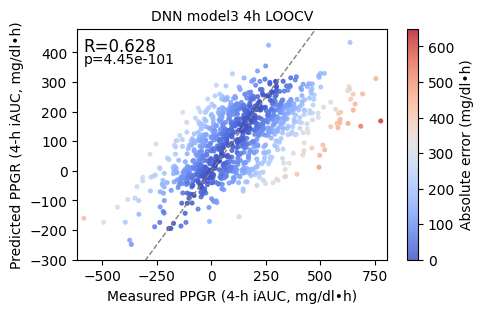

In [86]:
LOOCV_vis2(model3_predicted,actual_list,'3 4h')

In [87]:
predicted_ls = [v for y in model3_predicted for v in y.tolist()]
actual_ls = [v for y in actual_list for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 153.024097644204
MAE: 119.84712681812198


## Evaluation

The evaluation PCC is 0.633
ConfidenceInterval(low=0.5984165271656345, high=0.6650259075354983)


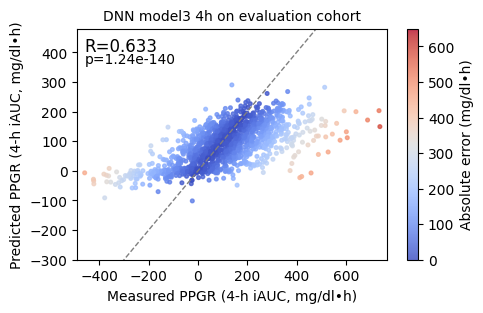

RMSE: 136.21673224180097
MAE: 102.9196231206322


In [88]:
model3 = Model3()

x_train_cgm = np.array(full_data[CGM_pre30_col]).astype(float)
x_val_cgm = np.array(evaluation_data[CGM_pre30_col]).astype(float)

meal_composition_scaler = MinMaxScaler()
x_train_meal_composition = meal_composition_scaler.fit_transform(full_data[meal_composition])
x_val_meal_composition = meal_composition_scaler.transform(evaluation_data[meal_composition])

meal_context_scaler = MinMaxScaler()
x_train_meal_context = meal_context_scaler.fit_transform(full_data[meal_context])
x_val_meal_context = meal_context_scaler.transform(evaluation_data[meal_context])

train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../evaluation/model3_best_model.h5',monitor='loss',save_best_only=True)
model3.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context],train_ppgr,epochs=20,batch_size=32,verbose=0,callbacks=[checkpoint]) # best epoch 20

pred_y = model3.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context],verbose=0)

r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
print(f"The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y.flatten(),val_ppgr,'3 4h')

print('RMSE:',mse(pred_y.flatten(),val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y.flatten(),val_ppgr).numpy())

# Model 4 : Meal composition + Meal context + CGM + clinical

In [46]:
def Model4():
    random.seed(2)
    np.random.seed(2)
    tf.random.set_seed(2)

    input_layer_cgm = Input(shape=(7, 1), name='CGM')
    input_layer_meal_composition = Input(shape=(8,), name='Meal composition')
    input_layer_meal_context = Input(shape=(3,), name='Meal context')
    input_layer_cli = Input(shape=(len(cli_col),), name='Clinical')

    CGM_features = CGM_representation(input_layer_cgm,6,8)                               
    clinical_features = clinical_representation(input_layer_cli,10)

    concat = concatenate([CGM_features,input_layer_meal_composition,input_layer_meal_context,clinical_features])
    output = fusion_regressor(concat,10,0.5)  # best regression units 25

    model = Model(inputs=[input_layer_cgm,input_layer_meal_composition,input_layer_meal_context,input_layer_cli], outputs=output)

    learning_rate = 0.005
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='mse')

    return model

In [89]:
data = full_data

model4_predicted = []
actual_list = []
model4_R_list = []

for sample in samples:
    model4 = Model4()
    print(f"Leave {sample} out validation start")
    
    train = data[data['ID']!=sample]
    val = data[data['ID']==sample]

    cgm_mean = train[CGM_pre30_col].values.mean()
    cgm_std = train[CGM_pre30_col].values.std()
    x_train_cgm = np.array((train[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    x_val_cgm = np.array((val[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    
    meal_composition_scaler = MinMaxScaler()
    x_train_meal_composition = meal_composition_scaler.fit_transform(train[meal_composition])
    x_val_meal_composition = meal_composition_scaler.transform(val[meal_composition])
    
    meal_context_scaler = MinMaxScaler()
    x_train_meal_context = meal_context_scaler.fit_transform(train[meal_context])
    x_val_meal_context = meal_context_scaler.transform(val[meal_context])

    cli_scaler = MinMaxScaler()
    x_train_cli = cli_scaler.fit_transform(train[cli_col])
    x_val_cli = cli_scaler.transform(val[cli_col])

    train_ppgr = np.array(train[PPGR_4])
    val_ppgr = np.array(val[PPGR_4])

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../main_LOOCV/model4_{sample}_best_model.h5',monitor='loss',save_best_only=True)
    model4.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context,x_train_cli],train_ppgr,epochs=80,batch_size=32,verbose=0,callbacks=[checkpoint]) #best epoch 80
    
    pred_y = model4.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_cli],verbose=0)
    model4_predicted.append(pred_y.flatten())
    actual_list.append(val_ppgr)

    r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
    model4_R_list.append(r)

    print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")

    predicted_ls = [v for y in model4_predicted for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    r, p = stats.pearsonr(predicted_ls, actual_ls)
    print(f"So far, R is {np.round(r,3)}")

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.719
So far, R is 0.719
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.831
So far, R is 0.797
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.785
So far, R is 0.769
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.878
So far, R is 0.785
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.846
So far, R is 0.786
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.73
So far, R is 0.758
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.801
So far, R is 0.742
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.364
So far, R is 0.726
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.618
So far, R is 0.72
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.694
So far, R i

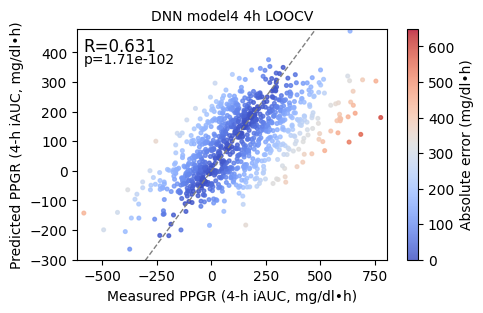

In [90]:
LOOCV_vis2(model4_predicted,actual_list,'4 4h')

In [91]:
predicted_ls = [v for y in model4_predicted for v in y.tolist()]
actual_ls = [v for y in actual_list for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 153.25695463022473
MAE: 119.25472750159527


## Evaluation

The evaluation PCC is 0.634
ConfidenceInterval(low=0.6001332688582187, high=0.6665173071137691)


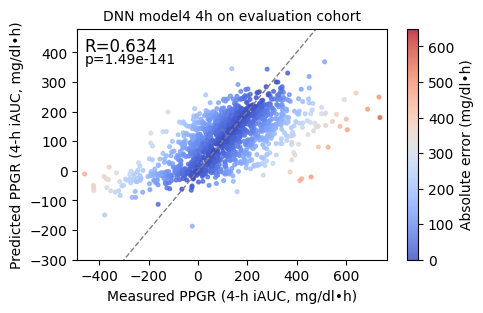

RMSE: 130.21694993411805
MAE: 99.49262720413314


In [92]:
model4 = Model4()

x_train_cgm = np.array(full_data[CGM_pre30_col]).astype(float)
x_val_cgm = np.array(evaluation_data[CGM_pre30_col]).astype(float)

meal_composition_scaler = MinMaxScaler()
x_train_meal_composition = meal_composition_scaler.fit_transform(full_data[meal_composition])
x_val_meal_composition = meal_composition_scaler.transform(evaluation_data[meal_composition])

meal_context_scaler = MinMaxScaler()
x_train_meal_context = meal_context_scaler.fit_transform(full_data[meal_context])
x_val_meal_context = meal_context_scaler.transform(evaluation_data[meal_context])

cli_scaler = MinMaxScaler()
x_train_cli = cli_scaler.fit_transform(full_data[cli_col])
x_val_cli = cli_scaler.transform(evaluation_data[cli_col])

train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../evaluation/model4_best_model.h5',monitor='loss',save_best_only=True)
model4.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context,x_train_cli],train_ppgr,epochs=30,batch_size=32,verbose=0,callbacks=[checkpoint]) #best epoch 50

pred_y = model4.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_cli],verbose=0)

r, p = stats.pearsonr(val_ppgr, pred_y.flatten())

print(f"The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y.flatten(),val_ppgr,'4 4h')

print('RMSE:',mse(pred_y.flatten(),val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y.flatten(),val_ppgr).numpy())

# Model 5 : Meal composition + Meal context + CGM + microbiome

In [51]:
def Model5():
    random.seed(2)
    np.random.seed(2)
    tf.random.set_seed(2)

    input_layer_cgm = Input(shape=(7, 1), name='CGM')
    input_layer_meal_composition = Input(shape=(8,), name='Meal composition')
    input_layer_meal_context = Input(shape=(3,), name='Meal context')
    input_layer_microbiome = Input(shape=(len(microbiome_col),), name='Microbiome')

    CGM_features = CGM_representation(input_layer_cgm,6,8)                               
    microbiome_features = microbiome_representation(input_layer_microbiome,20)
    
    concat = concatenate([CGM_features,input_layer_meal_composition,input_layer_meal_context,microbiome_features])
    output = fusion_regressor(concat,10,0.5)    # best regression units 20

    model = Model(inputs=[input_layer_cgm,input_layer_meal_composition,input_layer_meal_context,input_layer_microbiome], outputs=output)

    learning_rate = 0.005
    model.compile(optimizer = Adam(learning_rate=learning_rate),loss='mse')

    return model

In [93]:
data = full_data

model5_predicted = []
actual_list = []
model5_R_list = []

for sample in samples:
    train = data[data['ID']!=sample]
    val = data[data['ID']==sample]

    cgm_mean = train[CGM_pre30_col].values.mean()
    cgm_std = train[CGM_pre30_col].values.std()
    x_train_cgm = np.array((train[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    x_val_cgm = np.array((val[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    #x_train_cgm = np.array(train[CGM_pre30_col]).astype(float)
    #x_val_cgm = np.array(val[CGM_pre30_col]).astype(float)
    
    meal_composition_scaler = MinMaxScaler()
    x_train_meal_composition = meal_composition_scaler.fit_transform(train[meal_composition])
    x_val_meal_composition = meal_composition_scaler.transform(val[meal_composition])
    
    meal_context_scaler = MinMaxScaler()
    x_train_meal_context = meal_context_scaler.fit_transform(train[meal_context])
    x_val_meal_context = meal_context_scaler.transform(val[meal_context])
    
    microbiome_scaler = MinMaxScaler()
    x_train_microbiome = microbiome_scaler.fit_transform(train[microbiome_col])
    x_val_microbiome = microbiome_scaler.transform(val[microbiome_col])

    train_ppgr = np.array(train[PPGR_4])
    val_ppgr = np.array(val[PPGR_4])

    print(f"Leave {sample} out validation start")

    model5 = Model5()

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../main_LOOCV/model5_{sample}_best_model.h5',monitor='loss',save_best_only=True)
    model5.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context,x_train_microbiome],train_ppgr,epochs=80,batch_size=32,verbose=0,callbacks=[checkpoint]) #best epoch 80

    pred_y = model5.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_microbiome],verbose=0)
    model5_predicted.append(pred_y.flatten())
    actual_list.append(val_ppgr)

    r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
    model5_R_list.append(r)

    print(f" Leave {sample} out validation is done. The PCC is {np.round(r,3)}")

    predicted_ls = [v for y in model5_predicted for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    r, p = stats.pearsonr(predicted_ls, actual_ls)
    print(f" So far, R is {np.round(r,3)}")

Leave R01 out validation start
 Leave R01 out validation is done. The PCC is 0.706
 So far, R is 0.706
Leave R02 out validation start
 Leave R02 out validation is done. The PCC is 0.893
 So far, R is 0.816
Leave R03 out validation start
 Leave R03 out validation is done. The PCC is 0.8
 So far, R is 0.779
Leave R04 out validation start
 Leave R04 out validation is done. The PCC is 0.902
 So far, R is 0.8
Leave R05 out validation start
 Leave R05 out validation is done. The PCC is 0.858
 So far, R is 0.794
Leave R06 out validation start
 Leave R06 out validation is done. The PCC is 0.833
 So far, R is 0.786
Leave R07 out validation start
 Leave R07 out validation is done. The PCC is 0.812
 So far, R is 0.757
Leave R08 out validation start
 Leave R08 out validation is done. The PCC is 0.399
 So far, R is 0.729
Leave R09 out validation start
 Leave R09 out validation is done. The PCC is 0.412
 So far, R is 0.719
Leave R10 out validation start
 Leave R10 out validation is done. The PCC is 

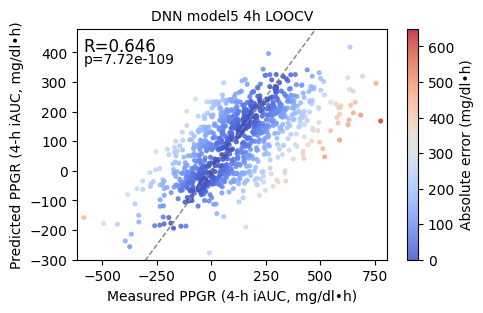

In [94]:
LOOCV_vis2(model5_predicted,actual_list,'5 4h')

In [95]:
predicted_ls = [v for y in model5_predicted for v in y.tolist()]
actual_ls = [v for y in actual_list for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 150.56763362281208
MAE: 116.75988348743832


## Evaluation

The evaluation PCC is 0.63
ConfidenceInterval(low=0.595262440265866, high=0.6622844454517288)


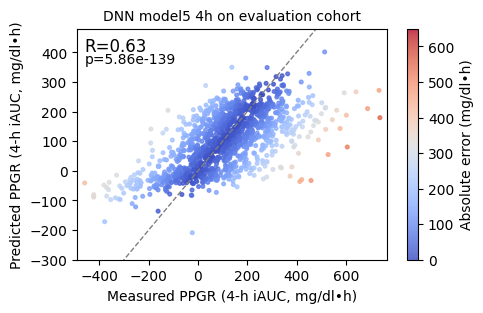

RMSE: 129.75553743666987
MAE: 99.62172202196003


In [96]:
model5 = Model5()

x_train_cgm = np.array(full_data[CGM_pre30_col]).astype(float)
x_val_cgm = np.array(evaluation_data[CGM_pre30_col]).astype(float)

meal_composition_scaler = MinMaxScaler()
x_train_meal_composition = meal_composition_scaler.fit_transform(full_data[meal_composition])
x_val_meal_composition = meal_composition_scaler.transform(evaluation_data[meal_composition])

meal_context_scaler = MinMaxScaler()
x_train_meal_context = meal_context_scaler.fit_transform(full_data[meal_context])
x_val_meal_context = meal_context_scaler.transform(evaluation_data[meal_context])

microbiome_scaler = MinMaxScaler()
x_train_microbiome = microbiome_scaler.fit_transform(full_data[microbiome_col])
x_val_microbiome = microbiome_scaler.transform(evaluation_data[microbiome_col])

train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../evaluation/model5_best_model.h5',monitor='loss',save_best_only=True)
model5.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context,x_train_microbiome],train_ppgr,epochs=40,batch_size=32,verbose=0,callbacks=[checkpoint]) #best epoch 20

pred_y = model5.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_microbiome],verbose=0)

r, p = stats.pearsonr(val_ppgr, pred_y.flatten())

print(f"The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y.flatten(),val_ppgr,'5 4h')

print('RMSE:',mse(pred_y.flatten(),val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y.flatten(),val_ppgr).numpy())

# Model 6 : Meal composition + Meal context + CGM + Medication

In [56]:
def Model6():
    random.seed(2)
    np.random.seed(2)
    tf.random.set_seed(2)
    
    input_layer_cgm = Input(shape=(7, 1), name='CGM')
    input_layer_meal_composition = Input(shape=(8,), name='Meal composition')
    input_layer_meal_context = Input(shape=(3,), name='Meal context')
    input_layer_med = Input(shape=(len(med_col),), name='Medication')

    CGM_features = CGM_representation(input_layer_cgm,6,8)                               
    medication_features = medication_representation(input_layer_med,5)
    
    concat = concatenate([CGM_features,input_layer_meal_composition,input_layer_meal_context,medication_features])
    output = fusion_regressor(concat,10,0.5)

    model = Model(inputs=[input_layer_cgm,input_layer_meal_composition,input_layer_meal_context,input_layer_med], outputs=output)

    learning_rate = 0.005
    model.compile(optimizer = Adam(learning_rate=learning_rate),loss='mse')
    
    return model

In [97]:
data = full_data

model6_predicted = []
actual_list = []
model6_R_list = []

for sample in samples:
    train = data[data['ID']!=sample]
    val = data[data['ID']==sample]

    cgm_mean = train[CGM_pre30_col].values.mean()
    cgm_std = train[CGM_pre30_col].values.std()
    x_train_cgm = np.array((train[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    x_val_cgm = np.array((val[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    #x_train_cgm = np.array(train[CGM_pre30_col]).astype(float)
    #x_val_cgm = np.array(val[CGM_pre30_col]).astype(float)
    
    meal_composition_scaler = MinMaxScaler()
    x_train_meal_composition = meal_composition_scaler.fit_transform(train[meal_composition])
    x_val_meal_composition = meal_composition_scaler.transform(val[meal_composition])
    
    meal_context_scaler = MinMaxScaler()
    x_train_meal_context = meal_context_scaler.fit_transform(train[meal_context])
    x_val_meal_context = meal_context_scaler.transform(val[meal_context])

    med_scaler = MinMaxScaler()
    x_train_med = med_scaler.fit_transform(train[med_col])
    x_val_med = med_scaler.transform(val[med_col])
    
    train_ppgr = np.array(train[PPGR_4])
    val_ppgr = np.array(val[PPGR_4])

    print(f"Leave {sample} out validation start")

    model6 = Model6()
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../main_LOOCV/model6_{sample}_best_model.h5',monitor='loss',save_best_only=True)
    model6.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context,x_train_med],train_ppgr,epochs=80,batch_size=32,verbose=0,callbacks=[checkpoint])

    pred_y = model6.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_med],verbose=0)
    model6_predicted.append(pred_y.flatten())
    actual_list.append(val_ppgr)

    r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
    model6_R_list.append(r)
    print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")
    
    predicted_ls = [v for y in model6_predicted for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    r, p = stats.pearsonr(predicted_ls, actual_ls)
    print(f"So far, R is {np.round(r,3)}")

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.713
So far, R is 0.713
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.882
So far, R is 0.828
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.804
So far, R is 0.792
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.887
So far, R is 0.804
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.866
So far, R is 0.782
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.751
So far, R is 0.774
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.852
So far, R is 0.758
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.366
So far, R is 0.738
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.413
So far, R is 0.722
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.567
So far, R

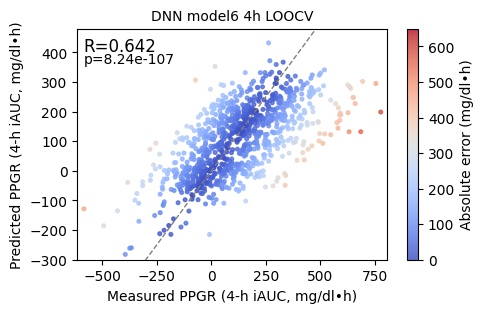

In [98]:
LOOCV_vis2(model6_predicted,actual_list,'6 4h')

In [99]:
predicted_ls = [v for y in model6_predicted for v in y.tolist()]
actual_ls = [v for y in actual_list for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 150.5654146936091
MAE: 117.42912349681737


## Evaluation

The evaluation PCC is 0.633
ConfidenceInterval(low=0.5985016148519774, high=0.6650998389988201)


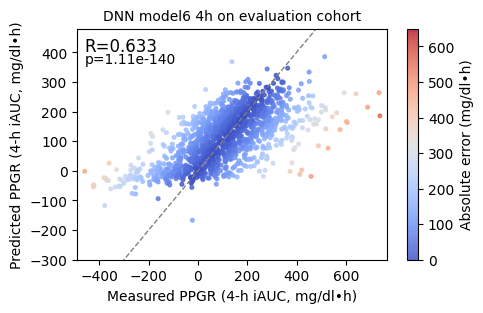

RMSE: 130.16668799476858
MAE: 99.57985981929504


In [102]:
model6 = Model6()

x_train_cgm = np.array(full_data[CGM_pre30_col]).astype(float)
x_val_cgm = np.array(evaluation_data[CGM_pre30_col]).astype(float)

meal_composition_scaler = MinMaxScaler()
x_train_meal_composition = meal_composition_scaler.fit_transform(full_data[meal_composition])
x_val_meal_composition = meal_composition_scaler.transform(evaluation_data[meal_composition])

meal_context_scaler = MinMaxScaler()
x_train_meal_context = meal_context_scaler.fit_transform(full_data[meal_context])
x_val_meal_context = meal_context_scaler.transform(evaluation_data[meal_context])

med_scaler = MinMaxScaler()
x_train_med = med_scaler.fit_transform(full_data[med_col]).astype(float)
x_val_med = med_scaler.transform(evaluation_data[med_col]).astype(float)

train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../evaluation/model6_best_model.h5',monitor='loss',save_best_only=True)
model6.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context,x_train_med],train_ppgr,epochs=40,batch_size=32,verbose=0,callbacks=[checkpoint]) #best epoch 20

pred_y = model6.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_med],verbose=0)

r, p = stats.pearsonr(val_ppgr, pred_y.flatten())

print(f"The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y.flatten(),val_ppgr,'6 4h')

print('RMSE:',mse(pred_y.flatten(),val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y.flatten(),val_ppgr).numpy())

# Model7 : meal composition + meal context + CGM + clinical + microbiome + medication

In [103]:
def Model7():
    random.seed(2)
    np.random.seed(2)
    tf.random.set_seed(2)

    input_layer_cgm = Input(shape=(7, 1), name='CGM')
    input_layer_meal_composition = Input(shape=(8,), name='Meal_composition')
    input_layer_meal_context = Input(shape=(3,), name='Meal_context')
    input_layer_microbiome = Input(shape=(len(microbiome_col),), name='Microbiome')
    input_layer_cli = Input(shape=(len(cli_col),), name='Clinical')
    input_layer_med = Input(shape=(len(med_col),), name='Medication')


    CGM_features = CGM_representation(input_layer_cgm,6,8)
    clinical_features = clinical_representation(input_layer_cli,10)
    microbiome_features = microbiome_representation(input_layer_microbiome,20) #best 30
    medication_features = medication_representation(input_layer_med,5)
    
    concat = concatenate([CGM_features,input_layer_meal_composition,input_layer_meal_context,clinical_features,microbiome_features,medication_features])#medication_features
    output = fusion_regressor(concat,20,0.5) # best 20,0.5

    model = Model(inputs=[input_layer_cgm,input_layer_meal_composition,input_layer_meal_context,input_layer_microbiome,input_layer_cli,input_layer_med], outputs=output)#input_layer_med

    learning_rate = 0.005                                                  # best learning rate 0.005
    model.compile(optimizer = Adam(learning_rate=learning_rate),loss='mse')
    
    return model

In [105]:
data = full_data

model7_predicted = []
actual_list = []
model7_R_list = []

for sample in samples:
    train = data[data['ID']!=sample]
    val = data[data['ID']==sample]

    cgm_mean = train[CGM_pre30_col].values.mean()
    cgm_std = train[CGM_pre30_col].values.std()
    x_train_cgm = np.array((train[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)
    x_val_cgm = np.array((val[CGM_pre30_col]-cgm_mean)/cgm_std).astype(float)

    meal_composition_scaler = MinMaxScaler()
    x_train_meal_composition = meal_composition_scaler.fit_transform(train[meal_composition])
    x_val_meal_composition = meal_composition_scaler.transform(val[meal_composition])
    
    meal_context_scaler = MinMaxScaler()
    x_train_meal_context = meal_context_scaler.fit_transform(train[meal_context])
    x_val_meal_context = meal_context_scaler.transform(val[meal_context])
    
    microbiome_scaler = MinMaxScaler()
    x_train_microbiome = microbiome_scaler.fit_transform(train[microbiome_col])
    x_val_microbiome = microbiome_scaler.transform(val[microbiome_col])
    
    cli_scaler = MinMaxScaler()
    x_train_cli = cli_scaler.fit_transform(train[cli_col])
    x_val_cli = cli_scaler.transform(val[cli_col])
    
    med_scaler = MinMaxScaler()
    x_train_med = med_scaler.fit_transform(train[med_col])
    x_val_med = med_scaler.transform(val[med_col])
    
    train_ppgr = np.array(train[PPGR_4])
    val_ppgr = np.array(val[PPGR_4])

    print(f"Leave {sample} out validation start")

    model7 = Model7()
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../main_LOOCV/model7_{sample}_best_model.h5',monitor='loss',save_best_only=True)
    model7.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context, x_train_microbiome,x_train_cli,x_train_med],train_ppgr,epochs=100,batch_size=32,verbose=0) #best epoch 80

    pred_y = model7.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_microbiome,x_val_cli,x_val_med],verbose=0)
    model7_predicted.append(pred_y.flatten())
    actual_list.append(val_ppgr)

    r, p = stats.pearsonr(val_ppgr, pred_y.flatten())
    model7_R_list.append(r)
    print(f"Leave {sample} out validation is done. The PCC is {np.round(r,3)}")
    
    predicted_ls = [v for y in model7_predicted for v in y.tolist()]
    actual_ls = [v for y in actual_list for v in y]
    r, p = stats.pearsonr(predicted_ls, actual_ls)
    print(f"So far, R is {np.round(r,3)}")

Leave R01 out validation start
Leave R01 out validation is done. The PCC is 0.703
So far, R is 0.703
Leave R02 out validation start
Leave R02 out validation is done. The PCC is 0.859
So far, R is 0.816
Leave R03 out validation start
Leave R03 out validation is done. The PCC is 0.833
So far, R is 0.786
Leave R04 out validation start
Leave R04 out validation is done. The PCC is 0.895
So far, R is 0.8
Leave R05 out validation start
Leave R05 out validation is done. The PCC is 0.808
So far, R is 0.79
Leave R06 out validation start
Leave R06 out validation is done. The PCC is 0.699
So far, R is 0.762
Leave R07 out validation start
Leave R07 out validation is done. The PCC is 0.808
So far, R is 0.724
Leave R08 out validation start
Leave R08 out validation is done. The PCC is 0.479
So far, R is 0.707
Leave R09 out validation start
Leave R09 out validation is done. The PCC is 0.582
So far, R is 0.706
Leave R10 out validation start
Leave R10 out validation is done. The PCC is 0.746
So far, R is

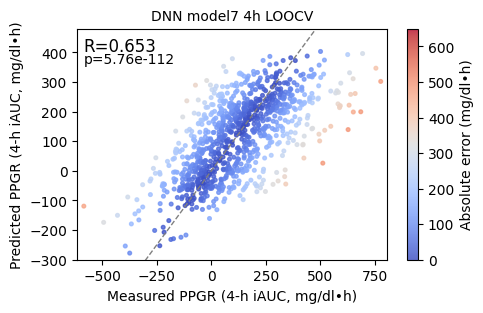

In [106]:
LOOCV_vis2(model7_predicted,actual_list,'7 4h')

In [107]:
predicted_ls = [v for y in model7_predicted for v in y.tolist()]
actual_ls = [v for y in actual_list for v in y]

print('RMSE:',mse(predicted_ls,actual_ls).numpy()**(1/2))
print('MAE:',mae(predicted_ls,actual_ls).numpy())

RMSE: 147.63689977844047
MAE: 117.26527703977355


## Evaluation

The evaluation PCC is 0.654
ConfidenceInterval(low=0.6213396662339734, high=0.6848964018988938)


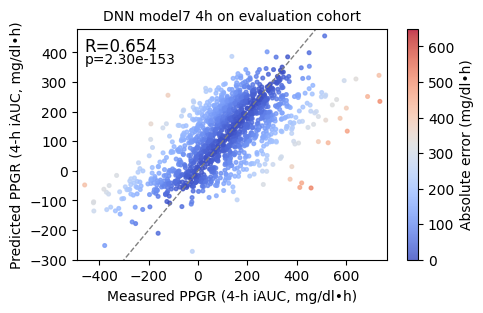

RMSE: 126.22929019671558
MAE: 97.53712788536251


In [108]:
model7 = Model7()


x_train_cgm = np.array(full_data[CGM_pre30_col]).astype(float)
x_val_cgm = np.array(evaluation_data[CGM_pre30_col]).astype(float)

meal_composition_scaler = MinMaxScaler()
x_train_meal_composition = meal_composition_scaler.fit_transform(full_data[meal_composition])
x_val_meal_composition = meal_composition_scaler.transform(evaluation_data[meal_composition])

meal_context_scaler = MinMaxScaler()
x_train_meal_context = meal_context_scaler.fit_transform(full_data[meal_context])
x_val_meal_context = meal_context_scaler.transform(evaluation_data[meal_context])

microbiome_scaler = MinMaxScaler()
x_train_microbiome = microbiome_scaler.fit_transform(full_data[microbiome_col])
x_val_microbiome =microbiome_scaler.transform(evaluation_data[microbiome_col])

cli_scaler = MinMaxScaler()
x_train_cli =  cli_scaler.fit_transform(full_data[cli_col])
x_val_cli = cli_scaler.transform(evaluation_data[cli_col])

med_scaler = MinMaxScaler()
x_train_med = med_scaler.fit_transform(full_data[med_col])
x_val_med = med_scaler.transform(evaluation_data[med_col])

train_ppgr = np.array(full_data[PPGR_4])
val_ppgr = np.array(evaluation_data[PPGR_4])

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'../evaluation/model7_best_model.h5',monitor='loss',save_best_only=True)
model7.fit([x_train_cgm,x_train_meal_composition,x_train_meal_context,x_train_microbiome,x_train_cli,x_train_med],train_ppgr,epochs=50,batch_size=32,verbose=0,callbacks=[checkpoint]) #best epoch 80

pred_y = model7.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context,x_val_microbiome,x_val_cli,x_val_med],verbose=0)

r, p = stats.pearsonr(val_ppgr, pred_y.flatten())

print(f"The evaluation PCC is {np.round(r,3)}")

Evaluation_vis(pred_y.flatten(),val_ppgr,'7 4h')

print('RMSE:',mse(pred_y.flatten(),val_ppgr).numpy()**(1/2))
print('MAE:',mae(pred_y.flatten(),val_ppgr).numpy())

# 결과 분석

## Error group analysis

In [115]:
(np.array(carb_sensitivity_p)>0.05).sum()

20

In [109]:
predicted_result = pred_y.flatten()
actual_list = val_ppgr
#predicted_result = np.array(predicted_ls)
#actual_list = np.array(actual_ls)

error_df = pd.DataFrame(columns=['ID','carb_sen','predicted','actual','abs_error','error_group'])
samples = list(evaluation_data['ID'].unique())
carb_sensitivity = []
carb_sensitivity_p = []
length = len(predicted_result)

for i,sample in enumerate(samples):
    data = evaluation_data[evaluation_data['ID']==sample]
    r,p = stats.pearsonr(data['Carb(g)'],data['PPGR_u2'])
    carb_sensitivity.append(r)
    carb_sensitivity_p.append(p)
carb_sensitivity_df = pd.DataFrame({'ID':samples,'carb_sen':carb_sensitivity,'p':carb_sensitivity_p})
    
error_df = pd.DataFrame({'ID':evaluation_data['ID'],'predicted':predicted_result,'actual':actual_list,
                    'abs_error':np.abs(predicted_result-actual_list),
                    'error':predicted_result-actual_list,
                    'error_group':['Higher_than_actual' if predicted_result[j]-actual_list[j]>baseline_error_median_eval else 'Lower_than_actual' if predicted_result[j]-actual_list[j]<-baseline_error_median_eval else 'Within' for j in range(len(predicted_result))]})
error_df = pd.merge(error_df,carb_sensitivity_df,how='left',on='ID')
error_df.loc[error_df['p']<=0.05,'carb_sen_cate']='high responder'
error_df.loc[error_df['p']>0.05,'carb_sen_cate']='low responder'


tf.Tensor(65.65338890817898, shape=(), dtype=float64)
tf.Tensor(76.73736364195877, shape=(), dtype=float64)
ConfidenceInterval(low=0.41247227397477526, high=0.5270958204027058)


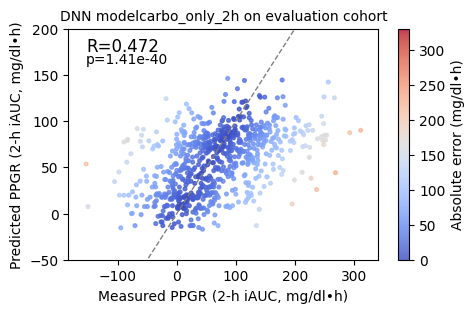

ConfidenceInterval(low=0.15623101075861867, high=0.31567506673532436)


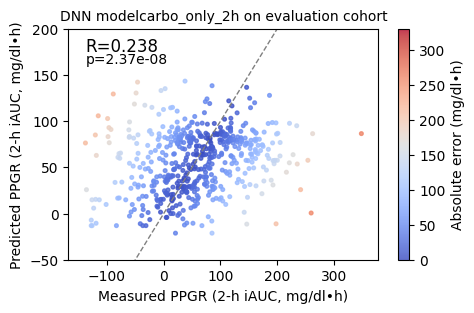

In [212]:
high = error_df[error_df['carb_sen_cate']=='high responder']
low = error_df[error_df['carb_sen_cate']=='low responder']
print(mse(high['actual'],high['predicted'])**(1/2))
print(mse(low['actual'],low['predicted'])**(1/2))
Evaluation_vis(high['predicted'],high['actual'],'carbo_only_2h')
Evaluation_vis(low['predicted'],low['actual'],'carbo_only_2h')

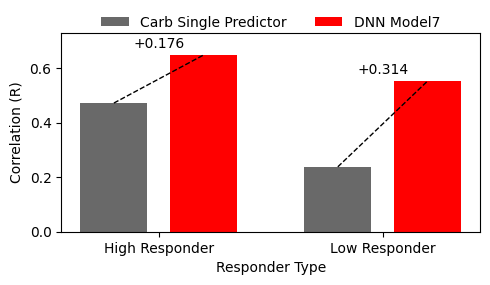

In [238]:
responders = ['High Responder', 'Low Responder']
carb_single = [0.472, 0.238]
dnn_model7 = [0.648, 0.552]
improvement = [dnn_model7[i] - carb_single[i] for i in range(len(carb_single))]

x = np.arange(len(responders))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(5,3))
bars1 = ax.bar(x - width/2-0.05, carb_single, width, label='Carb Single Predictor', color='dimgrey')
bars2 = ax.bar(x + width/2+0.05, dnn_model7, width, label='DNN Model7', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Responder Type')
ax.set_ylabel('Correlation (R)')
#ax.set_title('Improvement of DNN Model7 Over Carbohydrate Single Predictor')
ax.set_xticks(x)
ax.set_xticklabels(responders)
ax.set_ylim(0,0.73)
ax.legend(loc='upper center',ncol=2,bbox_to_anchor=(0.5,1.15),frameon=False)
ax.plot([-width/2-0.05, width/2+0.05],[carb_single[0], dnn_model7[0]], color='black', ls='--', zorder=1,linewidth=1)
ax.plot([1-width/2-0.05, 1+width/2+0.05],[carb_single[1], dnn_model7[1]], color='black', ls='--', zorder=1,linewidth=1)
# Add improvement annotations
for i in range(len(responders)):
    height = max(carb_single[i], dnn_model7[i])
    ax.annotate(f'+{improvement[i]:.3f}',
                xy=(x[i], height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.show()

### Error group vs carbohydrate sensitivity group analysis

In [545]:
error_df['error_group'].value_counts()

error_group
Within                723
Higher_than_actual    310
Lower_than_actual     215
Name: count, dtype: int64

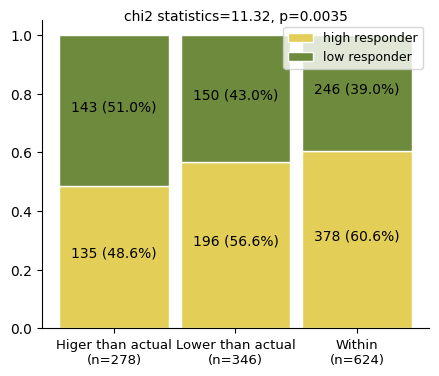

In [498]:
pivot = error_df.pivot_table(index='error_group',columns='carb_sen_cate',aggfunc='size')
res = stats.chi2_contingency(pivot)

proportion = pivot.div(pivot['low responder']+pivot['high responder'],axis=0)

barWidth = 0.9
COLOR_SCALE = ["#6E8B3D","#E3CF57"]
plt.style.use('default')
fig,ax = plt.subplots(figsize=(5,4))

# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.bar(x=pivot.index, height=pivot['high responder']/(pivot['low responder']+pivot['high responder']),width=barWidth,edgecolor='white',color=COLOR_SCALE[1],label='high responder')
ax.bar(x=pivot.index, height=pivot['low responder']/(pivot['low responder']+pivot['high responder']),bottom=pivot['high responder']/(pivot['low responder']+pivot['high responder']),
        width=barWidth,edgecolor='white',color=COLOR_SCALE[0],label='low responder')

ax.text('Higher_than_actual',proportion.iloc[0,0]/2,f'{pivot.iloc[0,0]} ({np.round(proportion.iloc[0,0]*100,1)}%)',ha="center")
ax.text('Higher_than_actual',proportion.iloc[0,0]+proportion.iloc[0,1]/2,f'{pivot.iloc[0,1]} ({np.round(proportion.iloc[0,1]*100)}%)',ha="center")
ax.text('Lower_than_actual',proportion.iloc[1,0]/2,f'{pivot.iloc[1,0]} ({np.round(proportion.iloc[1,0]*100,1)}%)',ha="center")
ax.text('Lower_than_actual',proportion.iloc[1,0]+proportion.iloc[1,1]/2,f'{pivot.iloc[1,1]} ({np.round(proportion.iloc[1,1]*100)}%)',ha="center")
ax.text('Within',proportion.iloc[2,0]/2,f'{pivot.iloc[2,0]} ({np.round(proportion.iloc[2,0]*100,1)}%)',ha="center")
ax.text('Within',proportion.iloc[2,0]+proportion.iloc[2,1]/2,f'{pivot.iloc[2,1]} ({np.round(proportion.iloc[2,1]*100)}%)',ha="center")

ax.text('Lower_than_actual',1.05, f'chi2 statistics={np.round(res.statistic,2)}, p={np.round(res.pvalue,4)}',ha="center")

xlabels = [f"{type_}\n(n={pivot.sum(axis=1)[i]})" for i, type_ in enumerate(['Higer than actual','Lower than actual','Within'])]
ax.set_xticks([0,1,2])
ax.set_xticklabels(xlabels, size=9.5, ha="center", ma="center")
plt.legend(fontsize=9)
plt.show()

### Error group carbohydrate sensitivity analysis

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lower_than_actual v.s. Within: t-test independent samples with Bonferroni correction, P_val=1.115e-03 stat=-3.572e+00
Higher_than_actual v.s. Lower_than_actual: t-test independent samples with Bonferroni correction, P_val=1.401e-01 stat=1.994e+00
Higher_than_actual v.s. Within: t-test independent samples with Bonferroni correction, P_val=5.125e-01 stat=-1.370e+00


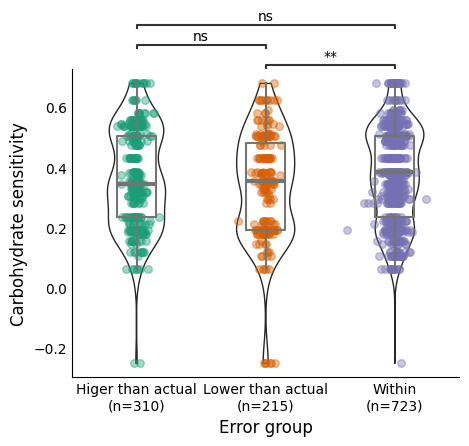

In [546]:
from statannot import add_stat_annotation
y_data = [error_df[error_df["error_group"] == type_]['carb_sen'].values for type_ in ['Higher_than_actual','Lower_than_actual','Within']]
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3"]

fig, ax = plt.subplots(figsize= (5, 4))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("Carbohydrate sensitivity", size=12)

violins = ax.violinplot(
    y_data, 
    positions=[0,1,2],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1,2], 
    showfliers = False, # Do not show the outliers beyond the caps.correlation heatmap with significance
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)


# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)

add_stat_annotation(ax, data=error_df,x='error_group',y='carb_sen',test='t-test_ind',order=['Higher_than_actual','Lower_than_actual','Within'],
                    box_pairs=[('Lower_than_actual','Within'),('Higher_than_actual','Lower_than_actual'),('Higher_than_actual','Within')],# text_offset=1,
                               line_height=0.01,line_offset=0.005,loc='outside', verbose=1, show_test_name=False,text_format="star")

xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['Higer than actual','Lower than actual','Within'])]
ax.set_xticks([0,1,2])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Error group", size=12)


plt.show()

### Error group clinical variable correlation

<Axes: xlabel='Within'>

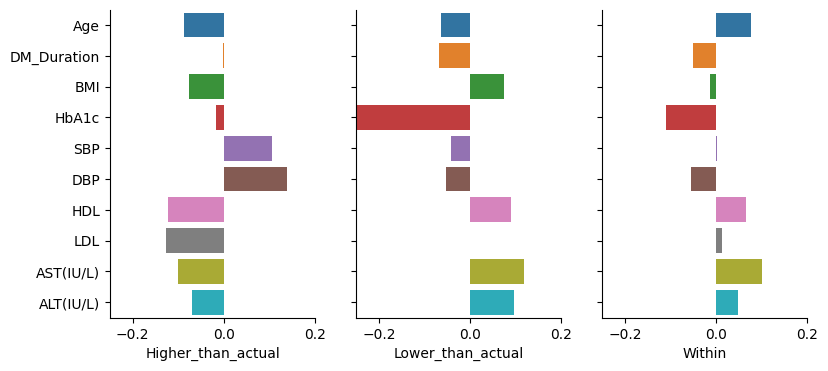

In [547]:
evaluation_clinical_data = evaluation_data.drop_duplicates('ID')

error_cli_df = pd.merge(error_df,evaluation_clinical_data,on='ID')
#error_cli_df = pd.merge(pd.merge(pd.merge(error_df,clinical_data,on='ID'),med_data,on='ID'),OTU_data,on='ID')
association_error_df = pd.DataFrame(index=cli_col,columns=['Higher_than_actual','Lower_than_actual','Within'])
                                    
higher_than_actual = error_cli_df[error_cli_df['error_group']=='Higher_than_actual']
lower_than_actual = error_cli_df[error_cli_df['error_group']=='Lower_than_actual']
within = error_cli_df[error_cli_df['error_group']=='Within']                           
                                    
for col in cli_col:
    r1,p1 = stats.pearsonr(higher_than_actual['error'],higher_than_actual[col])
    r2,p2 = stats.pearsonr(lower_than_actual['error'],lower_than_actual[col])
    r3,p3 = stats.pearsonr(within['error'],within[col])
    association_error_df.loc[col,'Higher_than_actual'] = r1
    association_error_df.loc[col,'Lower_than_actual'] = r2
    association_error_df.loc[col,'Within'] = r3
    
    
fig,axs = plt.subplots(1,3,sharey=True,figsize=(9,4))

for ax in axs:
    ax.set_xlim(-0.25,0.2)
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
sns.barplot(x=association_error_df['Higher_than_actual'],y=association_error_df.index, ax=axs[0])
sns.barplot(x=association_error_df['Lower_than_actual'],y=association_error_df.index, ax = axs[1])
sns.barplot(x=association_error_df['Within'],y=association_error_df.index, ax = axs[2])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

high responder v.s. low responder: t-test independent samples with Bonferroni correction, P_val=6.211e-03 stat=-2.741e+00


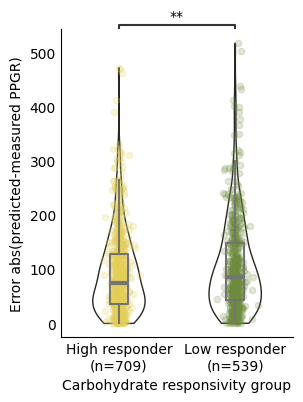

In [548]:
y_data = [error_df[error_df["carb_sen_cate"] == type_]['abs_error'].values for type_ in ['high responder','low responder']]
jitter = 0.03
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#E3CF57", "#6E8B3D"]

fig, ax = plt.subplots(figsize= (3, 4))

# Customize labels and ticks
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.tick_params(length=0)
ax.set_ylabel("Error abs(predicted-measured PPGR)", size=10)

violins = ax.violinplot(
    y_data, 
    positions=[0,1],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor('#282724')
    pc.set_linewidth(1)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=3, 
    color="#747473",
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color="#747473"
)
ax.boxplot(
    y_data,
    positions=[0,1], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 20, color=color, alpha=0.2)
    
add_stat_annotation(ax, data=error_df,x='carb_sen_cate',y='abs_error',test='t-test_ind',
                    box_pairs=[('high responder','low responder')], text_offset=1,
                    line_height=0.01,line_offset=0.005,text_format='star', loc='outside', verbose=1, show_test_name=False)

# xlabels accounts for the sample size for each species
xlabels = [f"{type_}\n(n={y_data[i].size})" for i, type_ in enumerate(['High responder','Low responder'])]
ax.set_xticks([0,1])
ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
ax.set_xlabel("Carbohydrate responsivity group", size=10)

plt.show()

### Clinical, microbiome, and medication variable correlation network

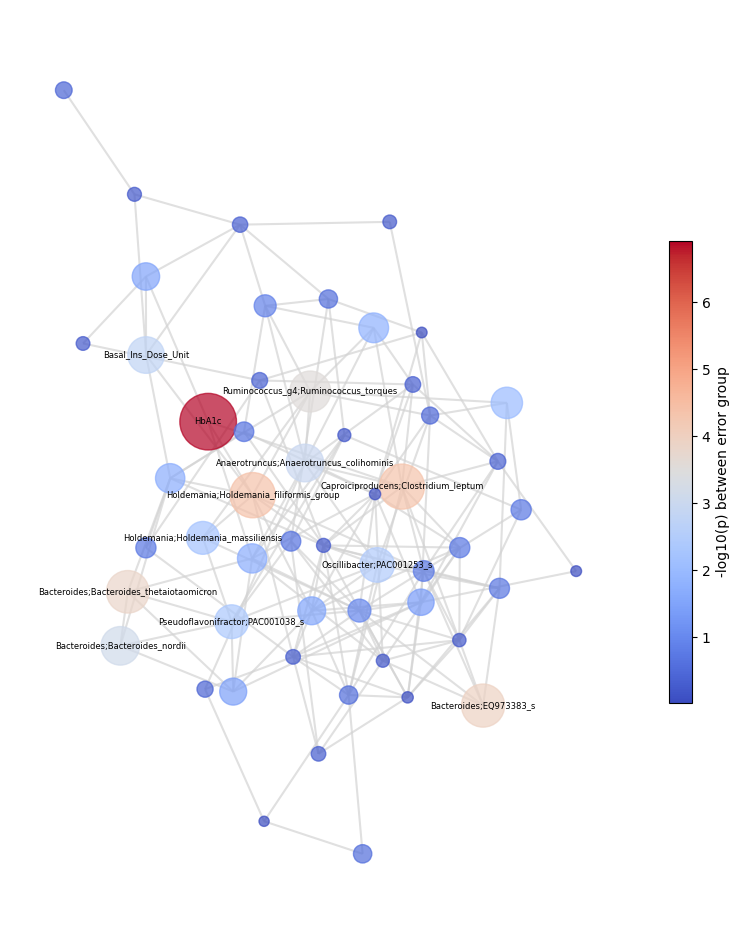

In [549]:
import networkx as nx

microbiome_col_ = [';'.join(var.split(';')[-2:]) for var in microbiome_col]
error_cli_df = error_cli_df.rename(columns = dict(zip(microbiome_col,microbiome_col_)))

# Make Correlation matrix (network)
corr_matrix = error_cli_df[cli_col+med_col+microbiome_col_].corr()

links = corr_matrix.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (np.abs(links['value']) > 0.3) & (links['var1'] != links['var2']) ]
    
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
pos = nx.kamada_kawai_layout(G)

# Calculate error group difference (color)
error_group_diff = []
error_group_diff_p = []
for var,_ in pos.items():
    s,p = stats.f_oneway(error_cli_df.loc[error_cli_df.error_group=='Higher_than_actual',var],
                  error_cli_df.loc[error_cli_df.error_group=='Lower_than_actual',var],
                  error_cli_df.loc[error_cli_df.error_group=='Within',var])
    error_group_diff.append(s)
    error_group_diff_p.append(-np.log10(p))

cmap=plt.cm.coolwarm
vmin = min(error_group_diff_p)
vmax = max(error_group_diff_p)

visible_node = []
for diff,node in zip(error_group_diff_p,pos.keys()):
    if diff > 2: #-log10(0.01)
        visible_node.append(node)

fig,ax = plt.subplots(figsize=(10,12))
nodes = nx.draw(G, pos, with_labels=False,node_color=error_group_diff_p, cmap=cmap, 
                node_size=[diff*100+50 for diff in error_group_diff], 
                edge_color='lightgray', linewidths=1, font_size=7,width=1.5,alpha=0.7)

visible_nodes = {node:node for node,label in pos.items() if node in visible_node}

nx.draw_networkx_labels(G, pos, labels=visible_nodes, font_size=6)

norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax=plt.gca(),shrink=0.5)
cbar.set_label('-log10(p) between error group', rotation=90)
#plt.savefig('../figure/corr_network2h.jpeg',dpi=300)
plt.show()

### Clinical, microbiome, and medication variable and model error

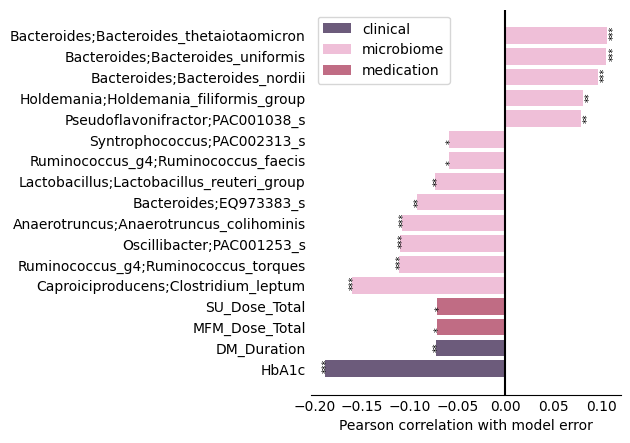

In [551]:
association_error_df = pd.DataFrame(columns=['PCC','p'])
source = ['clinical']*len(cli_col) + ['medication']*len(med_col) + ['microbiome']*len(microbiome_col_)
for i, col in enumerate(cli_col+med_col+microbiome_col_):
    r1,p1 = stats.pearsonr(error_cli_df['error'],error_cli_df[col])
    association_error_df.loc[col,'PCC'] = r1
    association_error_df.loc[col,'p'] = p1
    association_error_df.loc[col,'source'] = source[i]

association_error_df = association_error_df.sort_values(by=['source','PCC'])
association_error_df = association_error_df[association_error_df['p']<=0.05]
COLORS = {'clinical':"#6C5B7B",'microbiome':'#EFBFD8','medication':"#C06C84"}
c = association_error_df['source'].apply(lambda x: COLORS[x])

fig,axs = plt.subplots(figsize=(4,5))
plt.barh(data=association_error_df,y=association_error_df.index,width='PCC',color=c)
plt.axvline(x=0,color='black')
for i,p in enumerate(association_error_df['p']):
    pad=0.002
    text=''
    if list(association_error_df['PCC'])[i]<0:
        pad = -0.003
    if 0.01<p<=0.05:
        text='*'
    elif 0.001<p<=0.01:
        text='**'
    elif p<=0.001:
        text='***'
    plt.text(x=association_error_df.iloc[i,0]+pad,y=i-0.1,s=text,rotation=90,fontsize=7)

ax = plt.gca()
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(axis='both', length=0)
plt.xlabel('Pearson correlation with model error')
#plt.ylim(-0.5,len(microbiome_col)+len(cli_col)+len(med_col))
for i, j in COLORS.items(): #Loop over color dictionary
    plt.barh(data=association_error_df,y=association_error_df.index,width=0,color=j,label=i) #Plot invisible bar graph but have the legends specified
plt.legend(loc='best')
plt.savefig('../figure/err_personal_corr4h_eval.jpeg',dpi=300,bbox_inches='tight')
plt.show()

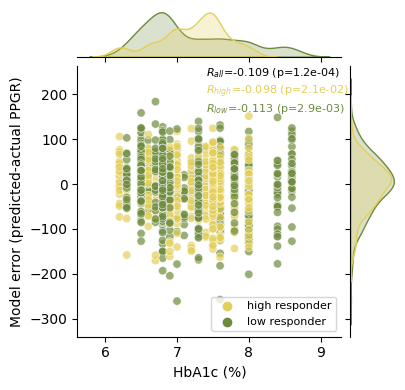

In [83]:
sen = error_cli_df[error_cli_df['carb_sen_cate']=='high responder']
not_sen = error_cli_df[error_cli_df['carb_sen_cate']=='low responder']
sen_r,sen_p = stats.pearsonr(sen['error'],sen['HbA1c'])
not_sen_r,not_sen_p = stats.pearsonr(not_sen['error'],not_sen['HbA1c'])

# Set your custom color palette
COLOR_SCALE = ["#E3CF57", "#6E8B3D"]
sns.set_palette(sns.color_palette(COLOR_SCALE))

#plt.figure(figsize=(2,2))
sns.jointplot(data=error_cli_df,x='HbA1c',y='error',hue='carb_sen_cate',alpha=0.7,height=4)
plt.text(7.4,240,r"$R_{all}$"+f"={np.round(association_error_df.loc['HbA1c','PCC'],3)} (p=%.1e)"%association_error_df.loc['HbA1c','p'],fontsize=8)
plt.text(7.4,200,r"$R_{high}$"+f"={np.round(sen_r,3)} (p=%.1e)"%sen_p,color=COLOR_SCALE[0],fontsize=8)
plt.text(7.4,160,r"$R_{low}$"+f"={np.round(not_sen_r,3)} (p=%.1e)"%not_sen_p,color=COLOR_SCALE[1],fontsize=8)
#plt.xlim(0,50)
#plt.ylim(-260,220)
plt.legend(loc='lower right',fontsize=8)
plt.xlabel('HbA1c (%)')
plt.ylabel('Model error (predicted-actual PPGR)')
plt.show()

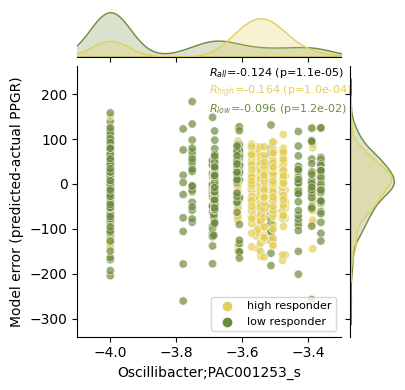

In [88]:
sen = error_cli_df[error_cli_df['carb_sen_cate']=='high responder']
not_sen = error_cli_df[error_cli_df['carb_sen_cate']=='low responder']
sen_r,sen_p = stats.pearsonr(sen['error'],sen['Oscillibacter;PAC001253_s'])
not_sen_r,not_sen_p = stats.pearsonr(not_sen['error'],not_sen['Oscillibacter;PAC001253_s'])

# Set your custom color palette
COLOR_SCALE = ["#E3CF57", "#6E8B3D"]
sns.set_palette(sns.color_palette(COLOR_SCALE))

#plt.figure(figsize=(3,3))
sns.jointplot(data=error_cli_df,x='Oscillibacter;PAC001253_s',y='error',hue='carb_sen_cate',alpha=0.7,height=4)
plt.text(-3.7,240,r"$R_{all}$"+f"={np.round(association_error_df.loc['Oscillibacter;PAC001253_s','PCC'],3)} (p=%.1e)"%association_error_df.loc['Oscillibacter;PAC001253_s','p'],fontsize=8)
plt.text(-3.7,200,r"$R_{high}$"+f"={np.round(sen_r,3)} (p=%.1e)"%sen_p,color=COLOR_SCALE[0],fontsize=8)
plt.text(-3.7,160,r"$R_{low}$"+f"={np.round(not_sen_r,3)} (p=%.1e)"%not_sen_p,color=COLOR_SCALE[1],fontsize=8)
plt.xlim(-4.1,-3.3)
#plt.ylim(-260,220)
plt.legend(loc='lower right',fontsize=8)
plt.xlabel('Oscillibacter;PAC001253_s')
plt.ylabel('Model error (predicted-actual PPGR)')
plt.show()

In [252]:
def clinical_boxplot(col,ax):
    y_data = [error_cli_df[error_cli_df["error_group"] == type_][col].values for type_ in ['Higher_than_actual','Lower_than_actual','Within']]
    jitter = 0.04
    x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
    x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
    COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3"]
    
    # Customize labels and ticks
    # Hide spines
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    
    ax.tick_params(length=0)
    ax.set_ylabel(col, size=10)
    medianprops = dict(
        linewidth=3, 
        color="black",
        solid_capstyle="butt"
    )
    boxprops = dict(
        linewidth=1.5, 
        color="black"
    )
    ax.boxplot(
        y_data,
        positions=[0,1,2], 
        showfliers = False, # Do not show the outliers beyond the caps.correlation heatmap with significance
        showcaps = False,   # Do not show the caps
        medianprops = medianprops,
        whiskerprops = boxprops,
        boxprops = boxprops
    )
    
    # Add jittered dots ----------------------------------------------
    for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
        ax.scatter(x, y, s = 10, color=color, alpha=0.2)
    
    add_stat_annotation(ax, data=error_cli_df,x='error_group',y=col,test='t-test_ind',order=['Higher_than_actual','Lower_than_actual','Within'],
                        box_pairs=[('Lower_than_actual','Within'),('Higher_than_actual','Lower_than_actual'),('Higher_than_actual','Within')],# text_offset=1,
                                   line_height=0.01,line_offset=0.05,verbose=0, show_test_name=False,text_format="star")#loc='outside'
    
    xlabels = [f"{type_}" for i, type_ in enumerate(['H','L','W'])]
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(xlabels, size=10, ha="center", ma="center")
    #ax.set_xlabel("Error group", size=12)
    

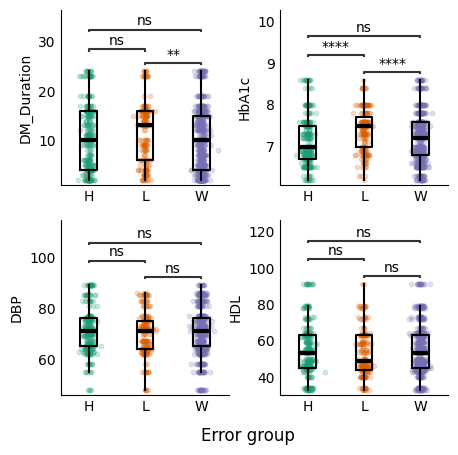

In [552]:
fig, ax = plt.subplots(2,2,figsize= (5, 5))
ax = ax.flatten()
for i,col in enumerate(['DM_Duration','HbA1c','DBP','HDL']):
    clinical_boxplot(col,ax[i])
fig.supxlabel('Error group')
plt.subplots_adjust(wspace=0.3)
plt.show()

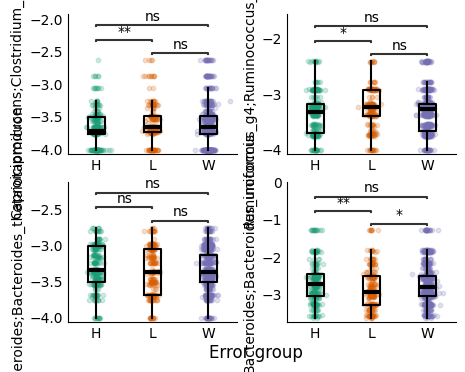

In [186]:
fig, ax = plt.subplots(2,2,figsize= (5, 4))
ax = ax.flatten()
for i,col in enumerate(['Caproiciproducens;Clostridium_leptum','Ruminococcus_g4;Ruminococcus_torques','Bacteroides;Bacteroides_thetaiotaomicron','Bacteroides;Bacteroides_uniformis']):
    clinical_boxplot(col,ax[i])
fig.supxlabel('Error group')
plt.subplots_adjust(wspace=0.3)
plt.show()

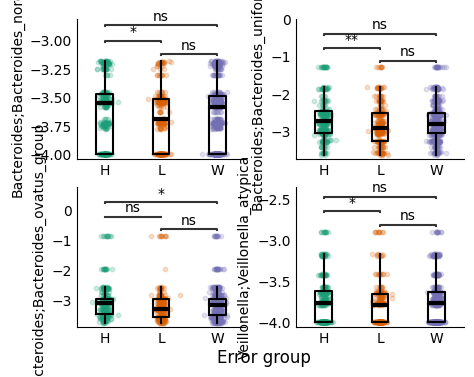

In [262]:
fig, ax = plt.subplots(2,2,figsize= (5, 4))
ax = ax.flatten()
for i,col in enumerate(['Bacteroides;Bacteroides_nordii','Bacteroides;Bacteroides_uniformis','Bacteroides;Bacteroides_ovatus_group','Veillonella;Veillonella_atypica']):
    clinical_boxplot(col,ax[i])
fig.supxlabel('Error group')
plt.subplots_adjust(wspace=0.3)
plt.show()

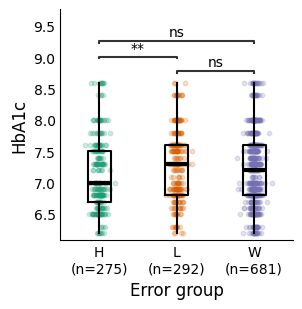

In [91]:
clinical_boxplot('HbA1c')

## Last layer UMAP

In [176]:
def adj_mat_clustering(activations, embedding, n_clusters=10):
    adj_matrix = pairwise_distances(activations,metric='manhattan')
    clustering = AgglomerativeClustering(n_clusters=n_clusters,metric='precomputed',linkage = 'complete').fit(adj_matrix)#,linkage='complete',
    
    plt.figure(figsize=(6,4))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=clustering.labels_,
        cmap=plt.cm.get_cmap('plasma', n_clusters),
        s=10,
        vmin = -0.5, vmax=n_clusters-0.5)
    plt.axis('off')
    
    cbar = plt.colorbar(norm=mcolors.Normalize(vmin=1, vmax=n_clusters))
    cbar.set_ticks(ticks=np.arange(0,n_clusters),labels=range(1,n_clusters+1))#
    cbar.set_label('Cluster', rotation=90)
    #plt.show()

    return clustering.labels_

### Model7 learned embedding

In [267]:
#pd.DataFrame(embedding).to_csv('../data/model7_embedding.csv')
pd.DataFrame(val_ppgr).to_csv('../data/actual.csv')

39/39 [==============================] - 0s 1ms/step
(1248, 2)


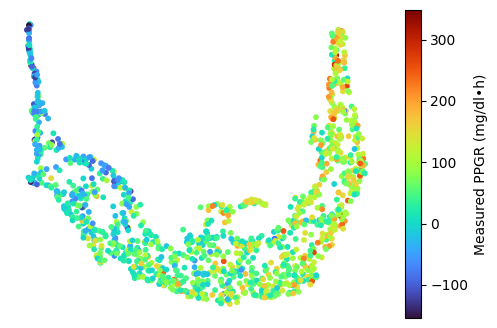

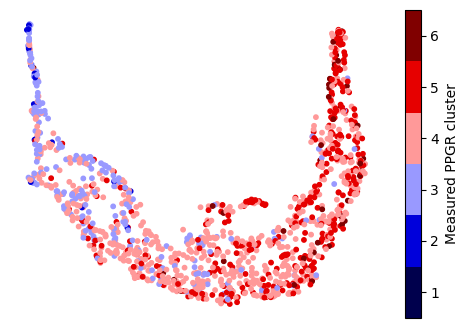

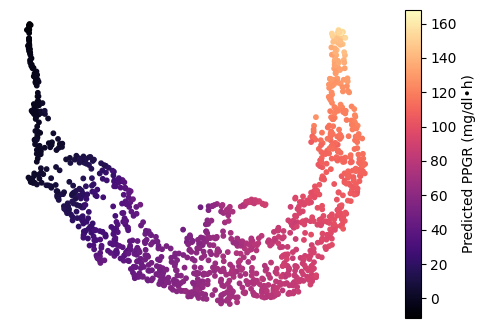

In [174]:
import umap.umap_ as umap

layer_output = model7.layers[-3].output
activation_model = Model(inputs=model7.input, outputs=layer_output)
activations = activation_model.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context, x_val_microbiome,x_val_cli,x_val_med])
predicted = model7.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context, x_val_microbiome,x_val_cli,x_val_med])

reducer = umap.UMAP(random_state=2,min_dist=0.3)
embedding = reducer.fit_transform(activations)
print(embedding.shape)

plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=val_ppgr,
    cmap="turbo",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Measured PPGR (mg/dl•h)', rotation=90)
plt.show()

bins = [val_ppgr.min(),-100,0,100,200,300,val_ppgr.max()]
labels = [1,2,3,4,5,6]
n_clusters=len(labels)
plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=pd.cut(val_ppgr,bins=bins,labels=labels,include_lowest = True),
    cmap=plt.cm.get_cmap('seismic', n_clusters),
    s=10,
    vmin = -0.5, vmax=n_clusters-0.5)
plt.axis('off')
cbar = plt.colorbar(norm=mcolors.Normalize(vmin=1, vmax=n_clusters))
cbar.set_ticks(ticks=np.arange(0,n_clusters),labels=range(1,n_clusters+1))#
cbar.set_label('Measured PPGR cluster', rotation=90)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=predicted.flatten(),
    cmap="magma",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Predicted PPGR (mg/dl•h)', rotation=90)
plt.show()

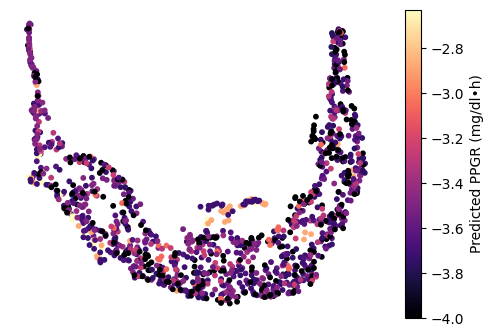

In [169]:
plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=evaluation_data['Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Caproiciproducens;Clostridium_leptum'],
    cmap="magma",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Predicted PPGR (mg/dl•h)', rotation=90)
plt.show()

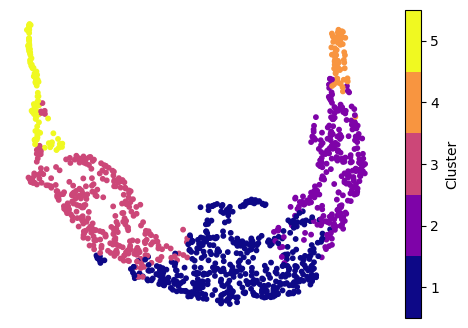

In [178]:
model7_cluster_labels = adj_mat_clustering(activations,embedding,5)
plt.savefig('../figure/UMAP_clustering_2h.jpeg',dpi=300)

In [198]:
pairwise_distances(activations,metric='manhattan')

array([[ 0.        ,  5.38253415, 41.34026551, ...,  8.23573017,
        20.76014841, 39.3359735 ],
       [ 5.38253415,  0.        , 35.95773137, ...,  4.36368406,
        15.37761426, 33.95343935],
       [41.34026551, 35.95773137,  0.        , ..., 33.10453534,
        20.58011711,  3.13194132],
       ...,
       [ 8.23573017,  4.36368406, 33.10453534, ...,  0.        ,
        12.52441823, 31.10024333],
       [20.76014841, 15.37761426, 20.58011711, ..., 12.52441823,
         0.        , 18.5758251 ],
       [39.3359735 , 33.95343935,  3.13194132, ..., 31.10024333,
        18.5758251 ,  0.        ]])

Cluster 1
Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Sellimonas;NFKJ_s 0.0010342906760291773
Bacteria;Firmicutes;Erysipelotrichi;Erysipelotrichales;Erysipelotrichaceae;Catenibacterium;PAC002523_s 0.0019286954541035918
Bacteria;Firmicutes;Erysipelotrichi;Erysipelotrichales;Erysipelotrichaceae;Holdemania;Holdemania_massiliensis 0.0032546654134309894
Bacteria;Firmicutes;Clostridia;Clostridiales;Mogibacterium_f;PAC001609_g;PAC001609_g_uc 0.0017978789432921316
Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Ruminococcus_g4;Ruminococcus_faecis 0.0037067221320587727
Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Rikenellaceae;Alistipes;Alistipes_obesi 0.006024102538581313
Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Sellimonas;NFKJ_s 0.0010342906760291773

Cluster 2
Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Caproiciproducens;Clostridium_leptum 1.2828904114060588e-06
DM_Duration 1.3078744773788874e-05
Bacteria;Firmicutes;Erysi

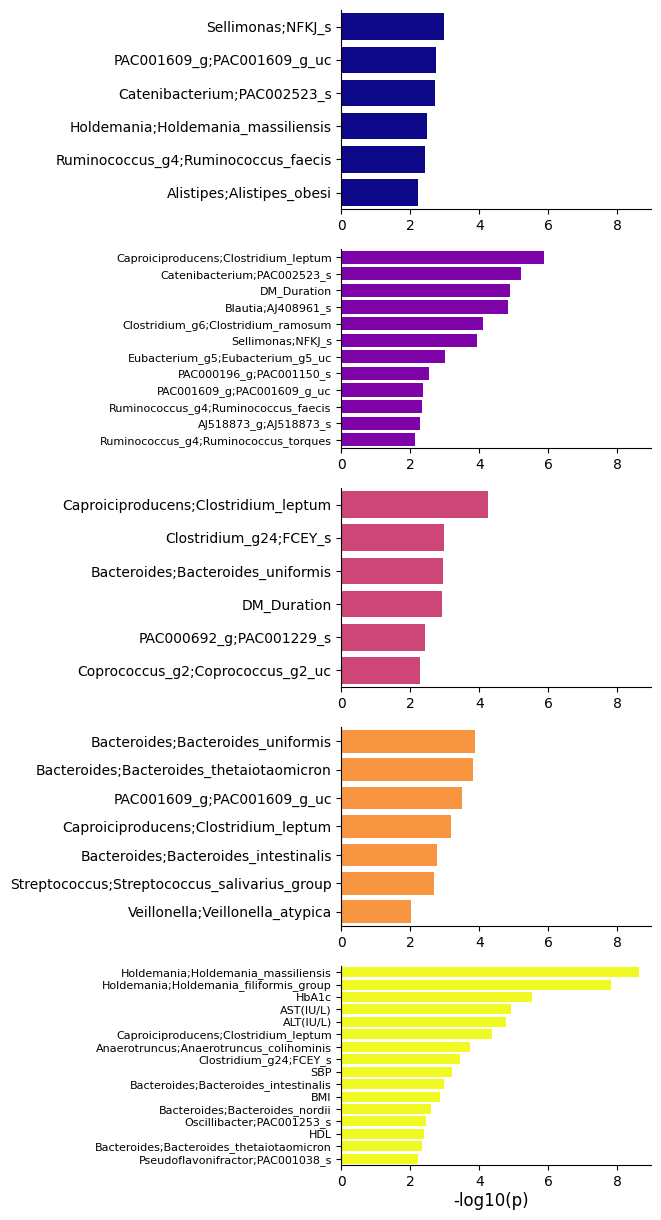

In [200]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

evaluation_data['model7_cluster']=model7_cluster_labels
fig,axes = plt.subplots(5,1,figsize=(4,15))
for i in range(5):
    
    print('Cluster',i+1)
    tmp_cluster = evaluation_data[evaluation_data['model7_cluster']==i]
    tmp_cluster_remain = evaluation_data[evaluation_data['model7_cluster']!=i]
    sig_col = {}
    for col in cli_col+microbiome_col+med_col: #meal_composition+meal_context+CGM_pre30_col+
        s,p = stats.mannwhitneyu(tmp_cluster[col].astype(float),tmp_cluster_remain[col].astype(float))
        if p < 0.01:
            sig_col[col] = p
    
    print(min(sig_col,key=sig_col.get), sig_col[min(sig_col,key=sig_col.get)])
    for x in sig_col:
        print(x,sig_col[x])
    print()
    
    sorted_sig_col = dict(sorted(sig_col.items(),key=lambda x:x[1],reverse=True))
    cols = [';'.join(col.split(';')[-2:]) for col in list(sorted_sig_col.keys())]
    axes[i].barh(y=cols,width=-np.log10(list(sorted_sig_col.values())),color=plt.cm.get_cmap('plasma', 5)(i))
    axes[i].set_xlim(0,9)
    axes[i].set_ylim(-0.5,len(sig_col)-0.5)
    axes[i].spines["right"].set_color("none")
    axes[i].spines["top"].set_color("none")
    if len(sig_col)>10:
        axes[i].tick_params(axis='y', labelsize=8)
fig.supxlabel('-log10(p)',y=0.08)
fig.subplots_adjust(hspace=0.2)

In [538]:
print(evaluation_data.loc[evaluation_data['model7_cluster']==4,'Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Anaerotruncus;Anaerotruncus_colihominis'].mean())
print(evaluation_data.loc[evaluation_data['model7_cluster']!=4,'Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Anaerotruncus;Anaerotruncus_colihominis'].mean())

-3.6661984016824536
-3.701267122138361


241.73
-211.77
79.31
164.51
-57.25


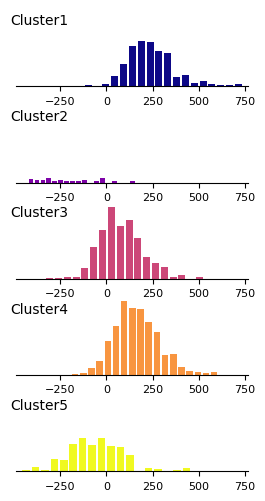

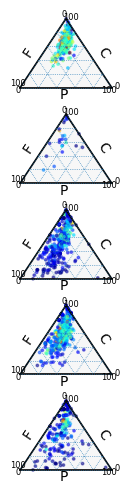

In [539]:
import ternary
#fig,axes = plt.subplots(6,1,figsize=(4,8))
fig,axes = plt.subplots(5,1,figsize=(3,6))
for i,ax in enumerate(axes.flat):
    cluster = evaluation_data.loc[evaluation_data['model7_cluster']==i,:]
    cluster_mean = np.round(cluster[PPGR_4].mean(),2)
    print(cluster_mean)
    ax.hist(cluster[PPGR_4],bins=18,rwidth=0.8,color=plt.cm.get_cmap('plasma', 5)(i))
    #ax.axvline(cluster_mean,linestyle='--',c='grey')
    ax.set_ylim(0,70)
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlim(val_ppgr.min()-30,val_ppgr.max()+30)
    ax.set_title('Cluster'+str(i+1),x=0.1,y=0.7,fontsize=10)
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.spines["left"].set_color("none")
    if i==5:
        ax.set_xlabel('Measured PPGR (mg/dl•h)',fontsize=10)
    else: ax.set_xlabel(None)
fig.subplots_adjust(hspace=0.25)
#plt.savefig('../figure/cluster_hist.jpeg',dpi=300)
plt.show()

#fig,axes = plt.subplots(6,1,figsize=(2.5,8))
fig,axes = plt.subplots(5,1,figsize=(2.5,6))
for i,ax in enumerate(axes.flat):
    cluster = evaluation_data.loc[evaluation_data['model7_cluster']==i,:]
    tfig, tax = ternary.figure(scale=100,ax=ax)
    tfig.set_size_inches(1.3,6)
    tax.boundary(linewidth=1.2)
    tax.gridlines(multiple=20)
    sct = tax.scatter(cluster[['Protein_pro','Carb_pro','Fat_pro']].values,s=3,alpha=0.5,c=cluster['Carb(g)'].astype(float).values,
                cmap='jet',colormap='jet',vmin=0,vmax=240)
    tax.ticks(axis='lbr', linewidth=0, multiple=100,fontsize=6,offset=0.02)
    tax.bottom_axis_label("P", fontsize=10,offset=0.09)
    tax.right_axis_label("C", fontsize=10,offset=0.14)
    tax.left_axis_label("F", fontsize=10,offset=0.14)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    #cb = sct.figure.colorbar(sct.collections[0],shrink=1)
    #cb.ax.tick_params(labelsize=6)
    #cb.set_label('carbohydrate(g)', rotation=90,fontsize=8)
fig.subplots_adjust(hspace=0.2)
#plt.savefig('../figure/cluster_ternary.jpeg',dpi=300)
plt.show()

In [191]:
cluster[CGM_pre30_col+CGM_post120_col[1:]]

m_030  m_025  m_020  m_015  m_010  m_005  p_000  p_005  p_010  p_015  \
3     118.0  112.0  110.0  112.0  109.0  108.0  103.0   97.0   99.0  112.0   
9     101.0   95.0   90.0   86.0   85.0   86.0   85.0   84.0   84.0   87.0   
10     90.0   87.0   90.0   93.0   95.0   94.0   92.0   87.0   86.0   96.0   
14     94.0   94.0   96.0   96.0   91.0   88.0   89.0   87.0   93.0  105.0   
15     85.0   85.0   86.0   83.0   82.0   84.0   85.0   86.0   87.0   90.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1239  139.0  140.0  142.0  146.0  143.0  138.0  138.0  132.0  124.0  116.0   
1241  146.0  145.0  144.0  146.0  148.0  149.0  149.0  147.0  145.0  142.0   
1242  136.0  136.0  136.0  136.0  139.0  139.0  142.0  141.0  140.0  141.0   
1244  125.0  127.0  128.0  125.0  134.0  142.0  145.0  151.0  165.0  168.0   
1246  127.0  122.0  116.0  113.0  109.0  100.0   95.0   96.0   98.0  101.0   

      ...  p_075  p_080  p_085  p_090  p_095  p_100  p_105  p_110  p_115  \
3     ...  138.0  148.0  161.0  181.0  190.0  197.0  198.0  203.0  214.0   
9     ...  118.0  116.0  111.0  106.0  103.0  100.0  101.0  106.0  109.0   
10    ...  129.0  127.0  126.0  123.0  121.0  123.0  125.0  122.0  121.0   
14    ...  119.0  117.0  116.0  121.0  123.0  125.0  131.0  133.0  132.0   
15    ...   87.0   87.0   86.0   85.0   84.0   83.0   82.0   81.0   81.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1239  ...  145.0  136.0  126.0  120.0  118.0  117.0  111.0  112.0  113.0   
1241  ...  184.0  181.0  181.0  184.0  190.0  195.0  198.0  202.0  205.0   
1242  ...  159.0  152.0  147.0  146.0  146.0  146.0  150.0  148.0  153.0   
1244  ...  195.0  197.0  198.0  200.0  201.0  200.0  204.0  203.0  202.0   
1246  ...  123.0  125.0  124.0  125.0  128.0  128.0  126.0  127.0  129.0   

      p_120  
3     225.0  
9     112.0  
10    119.0  
14    131.0  
15     81.0  
...     ...  
1239  117.0  
1241  206.0  
1242  156.0  
1244  201.0  
1246  130.0  

[490 rows x 31 columns]

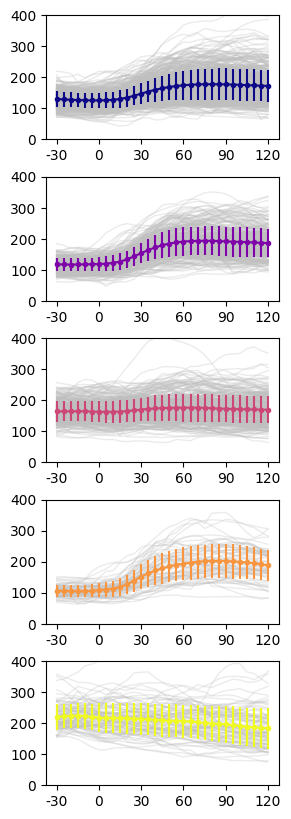

In [195]:
fig,axes = plt.subplots(5,1,figsize=(3,10))
for i,ax in enumerate(axes.flat):
    cluster = evaluation_data.loc[evaluation_data['model7_cluster']==i,:]
    ax.plot(cluster[CGM_pre30_col+CGM_post120_col[1:]].T,color="#BFBFBF",  lw=1,alpha=0.3)#BFBFBF
    ax.set_ylim(0,400)
    ax.errorbar(x=CGM_pre30_col+CGM_post120_col[1:],y=cluster[CGM_pre30_col+CGM_post120_col[1:]].mean(axis=0), yerr=cluster[CGM_pre30_col+CGM_post120_col[1:]].std(axis=0),marker='o', markersize=3, color=plt.cm.get_cmap('plasma', 5)(i),markeredgecolor=plt.cm.get_cmap('plasma', 5)(i),lw=1.5)
    
    ax.set_xticks(['m_030','p_000','p_030','p_060','p_090','p_120'])
    ax.set_xticklabels(['-30','0','30','60','90','120'])
fig.subplots_adjust(hspace=0.3)

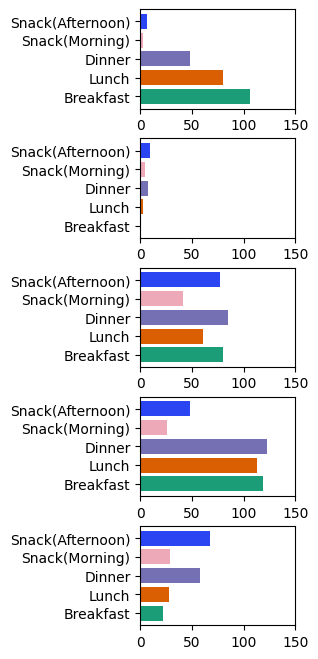

In [518]:
fig,axes = plt.subplots(5,1,figsize=(2,8))
for i,ax in enumerate(axes.flat):
    cluster = evaluation_data.loc[evaluation_data['model7_cluster']==i,:]
    cluster['Meal'].value_counts().sort_index().plot(kind='barh',ax=ax,color=["#1B9E77", "#D95F02", "#7570B3",'#EEA9B8',"#2B45F2"],width=0.8)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(['Breakfast','Lunch','Dinner','Snack(Morning)','Snack(Afternoon)'] )
    ax.set_xlim(0,150)
    ax.set_ylabel(None)
fig.subplots_adjust(hspace=0.3)

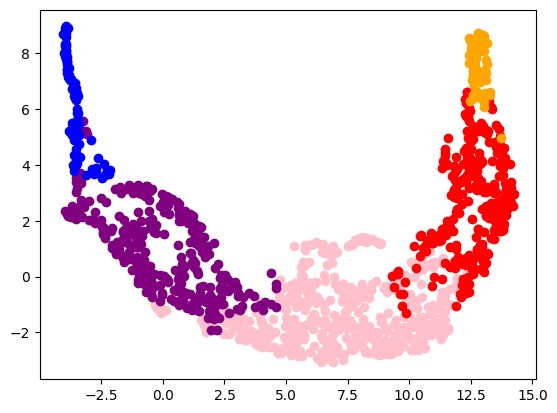

In [372]:
plt.scatter(embedding[evaluation_data.loc[evaluation_data['model7_cluster']==0,:].index,0],embedding[evaluation_data.loc[evaluation_data['model7_cluster']==0,:].index,1],c='pink')
plt.scatter(embedding[evaluation_data.loc[evaluation_data['model7_cluster']==1,:].index,0],embedding[evaluation_data.loc[evaluation_data['model7_cluster']==1,:].index,1],c='red')
plt.scatter(embedding[evaluation_data.loc[evaluation_data['model7_cluster']==2,:].index,0],embedding[evaluation_data.loc[evaluation_data['model7_cluster']==2,:].index,1],c='purple')
plt.scatter(embedding[evaluation_data.loc[evaluation_data['model7_cluster']==3,:].index,0],embedding[evaluation_data.loc[evaluation_data['model7_cluster']==3,:].index,1],c='orange')
plt.scatter(embedding[evaluation_data.loc[evaluation_data['model7_cluster']==4,:].index,0],embedding[evaluation_data.loc[evaluation_data['model7_cluster']==4,:].index,1],c='blue')

### Model1 learned embedding

39/39 [==============================] - 0s 684us/step
(1248, 2)


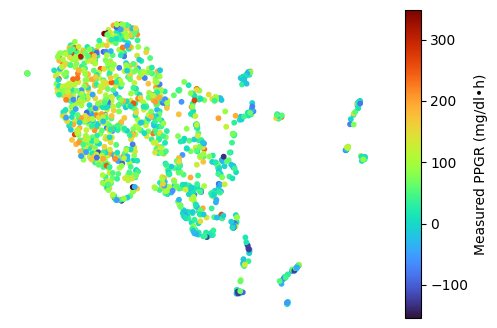

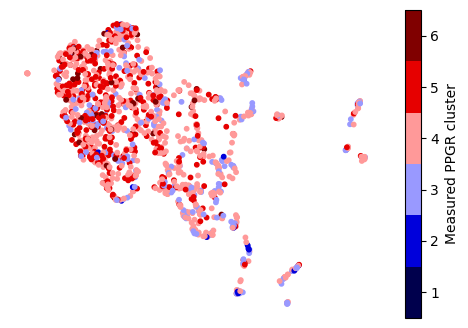

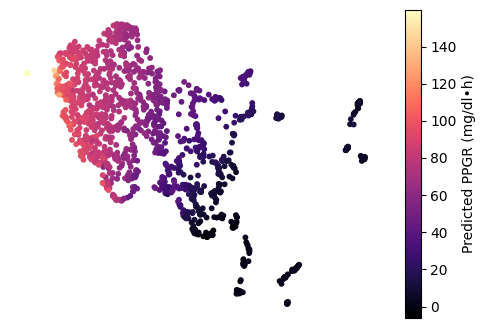

In [48]:
layer_output = model1.layers[-3].output
activation_model = Model(inputs=model1.input, outputs=layer_output)
activations = activation_model.predict(x_val_meal_composition)
predicted = model1.predict(x_val_meal_composition)

reducer = umap.UMAP(random_state=2,min_dist=0.3)
embedding = reducer.fit_transform(activations)
print(embedding.shape)

plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=val_ppgr,
    cmap="turbo",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Measured PPGR (mg/dl•h)', rotation=90)
plt.show()

bins = [val_ppgr.min(),-100,0,100,200,300,val_ppgr.max()]
labels = [1,2,3,4,5,6]
n_clusters=len(labels)
plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=pd.cut(val_ppgr,bins=bins,labels=labels,include_lowest = True),
    cmap=plt.cm.get_cmap('seismic', n_clusters),
    s=10,
    vmin = -0.5, vmax=n_clusters-0.5)
plt.axis('off')
cbar = plt.colorbar(norm=mcolors.Normalize(vmin=1, vmax=n_clusters))
cbar.set_ticks(ticks=np.arange(0,n_clusters),labels=range(1,n_clusters+1))#
cbar.set_label('Measured PPGR cluster', rotation=90)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=predicted.flatten(),
    cmap="magma",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Predicted PPGR (mg/dl•h)', rotation=90)
plt.show()

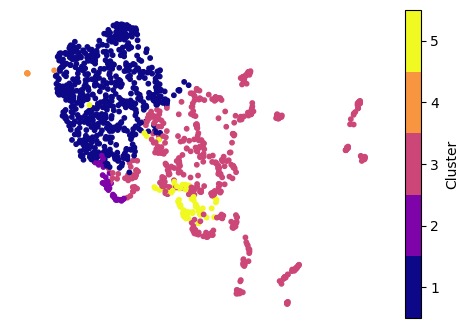

In [374]:
model1_cluster_labels = adj_mat_clustering(activations,embedding,5)

### Model3 learned embedding

39/39 [==============================] - 0s 1ms/step
(1248, 2)


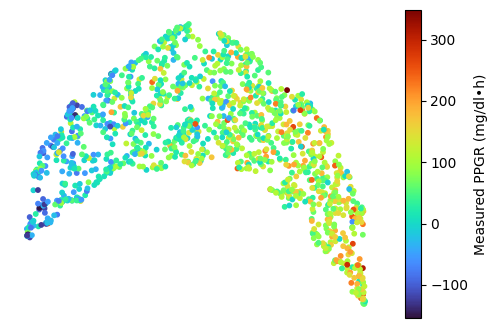

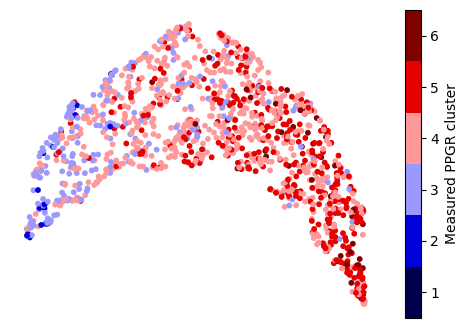

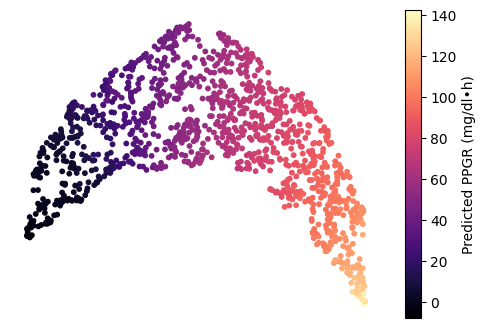

In [378]:
layer_output = model3.layers[-3].output
activation_model = Model(inputs=model3.input, outputs=layer_output)
activations = activation_model.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context])
predicted = model3.predict([x_val_cgm,x_val_meal_composition,x_val_meal_context])

reducer = umap.UMAP(random_state=2,min_dist=0.3)
embedding = reducer.fit_transform(activations)
print(embedding.shape)

plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=val_ppgr,
    cmap="turbo",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Measured PPGR (mg/dl•h)', rotation=90)
plt.show()

bins = [val_ppgr.min(),-100,0,100,200,300,val_ppgr.max()]
labels = [1,2,3,4,5,6]
n_clusters=len(labels)
plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=pd.cut(val_ppgr,bins=bins,labels=labels,include_lowest = True),
    cmap=plt.cm.get_cmap('seismic', n_clusters),
    s=10,
    vmin = -0.5, vmax=n_clusters-0.5)
plt.axis('off')
cbar = plt.colorbar(norm=mcolors.Normalize(vmin=1, vmax=n_clusters))
cbar.set_ticks(ticks=np.arange(0,n_clusters),labels=range(1,n_clusters+1))#
cbar.set_label('Measured PPGR cluster', rotation=90)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=predicted.flatten(),
    cmap="magma",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Predicted PPGR (mg/dl•h)', rotation=90)
plt.show()

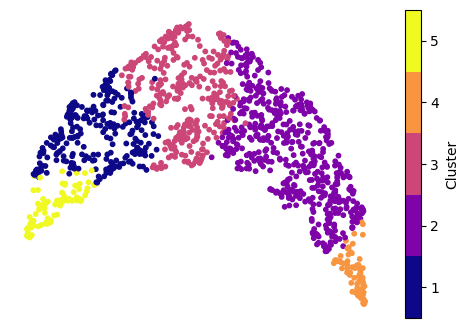

In [379]:
model3_cluster_labels = adj_mat_clustering(activations,embedding,5)

### Raw data 

(1248, 2)


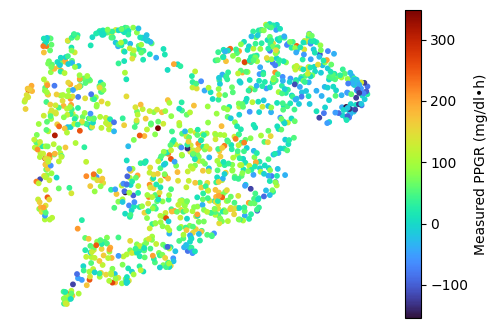

In [381]:
raw_embedding = evaluation_data[meal_composition+meal_context+CGM_pre30_col+cli_col+microbiome_col+med_col]

reducer = umap.UMAP(random_state=2,min_dist=0.3)
embedding = reducer.fit_transform(raw_embedding)
print(embedding.shape)

plt.figure(figsize=(6,4))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=val_ppgr,
    cmap="turbo",
    s=10)
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Measured PPGR (mg/dl•h)', rotation=90)
plt.gca().set_aspect('equal', 'datalim')
plt.show()

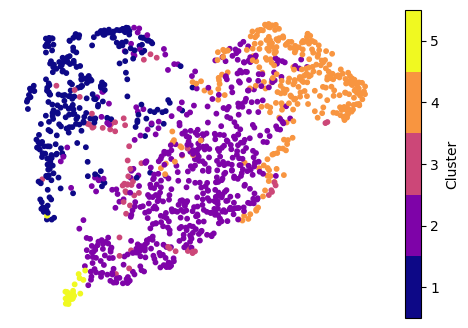

In [382]:
raw_cluster_labels = adj_mat_clustering(raw_embedding,embedding,5)

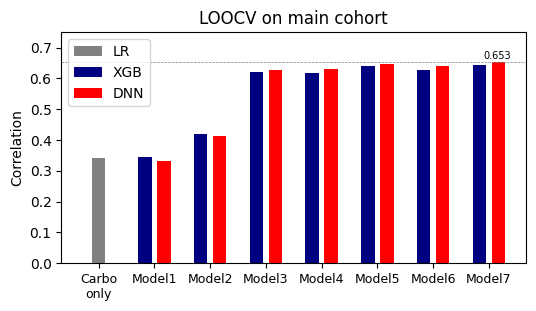

In [127]:
performance_df = pd.read_excel('../data/model_performance.xlsx',sheet_name='4hPPGR_main',index_col=0)
barWidth = 0.24
r1 = np.arange(len(performance_df))
r2 = [x - barWidth/2-0.05 for x in r1]
r3 = [x + barWidth/2+0.05 for x in r1]

plt.figure(figsize=(6,3))
plt.bar(x=r1,height=performance_df['LR'], width=barWidth,label='LR',color='grey')
plt.bar(x=r2,height=performance_df['XGB'], width=barWidth,label='XGB',color='navy')
plt.bar(x=r3,height=performance_df['DNN'], width=barWidth,label='DNN',color='red')
plt.text(x=r1[-1]-0.1,y=performance_df.loc['model7','DNN']+0.01,s=performance_df.loc['model7','DNN'],fontsize=7)
plt.axhline(y=performance_df[['XGB','DNN']].max().max(),linestyle='--',color='grey',linewidth=0.5)
plt.xticks(r1, ['Carbo\nonly','Model1','Model2','Model3','Model4','Model5','Model6','Model7'],fontsize=9)
plt.ylabel('Correlation')
plt.ylim(0,0.75)
plt.title('LOOCV on main cohort')
plt.legend()
plt.show()

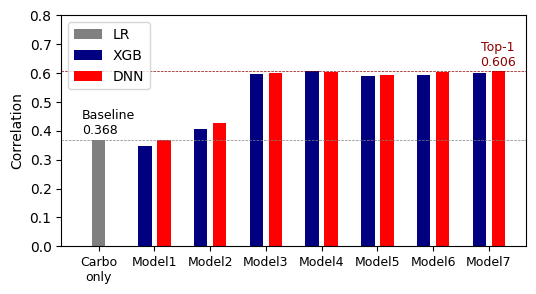

In [167]:
performance_df = pd.read_excel('../data/model_performance.xlsx',sheet_name='2hPPGR_evaluation',index_col=0)
barWidth = 0.24
r1 = np.arange(len(performance_df))
r2 = [x - barWidth/2-0.05 for x in r1]
r3 = [x + barWidth/2+0.05 for x in r1]

plt.figure(figsize=(6,3))
plt.bar(x=r1,height=performance_df['LR'], width=barWidth,label='LR',color='grey')
plt.bar(x=r2,height=performance_df['XGB'], width=barWidth,label='XGB',color='navy')
plt.bar(x=r3,height=performance_df['DNN'], width=barWidth,label='DNN',color='red')
plt.text(x=r1[0]-0.3,y=performance_df.loc['Carbohydrate only','LR']+0.02,s='Baseline\n'+str(performance_df.loc['Carbohydrate only','LR']),fontsize=9)
plt.text(x=r1[-1]-0.15,y=performance_df.loc['model7','DNN']+0.02,s='Top-1\n'+str(performance_df.loc['model7','DNN']),fontsize=9,color='darkred')
plt.axhline(y=performance_df.loc['Carbohydrate only','LR'],linestyle='--',color='grey',linewidth=0.5)
plt.axhline(y=performance_df[['XGB','DNN']].max().max(),linestyle='--',color='darkred',linewidth=0.5)
plt.xticks(r1, ['Carbo\nonly','Model1','Model2','Model3','Model4','Model5','Model6','Model7'],fontsize=9)
plt.ylabel('Correlation')
plt.ylim(0,0.8)
#plt.title('LOOCV on main cohort')
plt.legend()
plt.show()

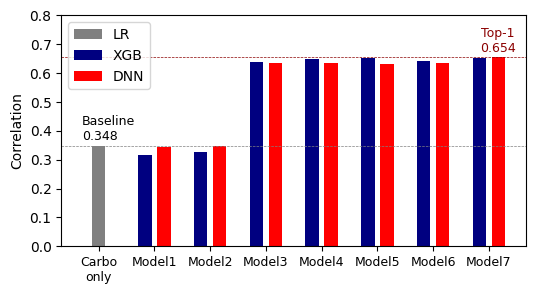

In [154]:
performance_df = pd.read_excel('../data/model_performance.xlsx',sheet_name='4hPPGR_evaluation',index_col=0)
barWidth = 0.24
r1 = np.arange(len(performance_df))
r2 = [x - barWidth/2-0.05 for x in r1]
r3 = [x + barWidth/2+0.05 for x in r1]

plt.figure(figsize=(6,3))
plt.bar(x=r1,height=performance_df['LR'], width=barWidth,label='LR',color='grey')
plt.bar(x=r2,height=performance_df['XGB'], width=barWidth,label='XGB',color='navy')
plt.bar(x=r3,height=performance_df['DNN'], width=barWidth,label='DNN',color='red')
plt.text(x=r1[0]-0.3,y=performance_df.loc['Carbohydrate only','LR']+0.02,s='Baseline\n'+str(performance_df.loc['Carbohydrate only','LR']),fontsize=9)
plt.text(x=r1[-1]-0.15,y=performance_df.loc['model7','DNN']+0.02,s='Top-1\n'+str(performance_df.loc['model7','DNN']),fontsize=9,color='darkred')
plt.axhline(y=performance_df.loc['Carbohydrate only','LR'],linestyle='--',color='grey',linewidth=0.5)
plt.axhline(y=performance_df[['XGB','DNN']].max().max(),linestyle='--',color='darkred',linewidth=0.5)
plt.xticks(r1, ['Carbo\nonly','Model1','Model2','Model3','Model4','Model5','Model6','Model7'],fontsize=9)
plt.ylabel('Correlation')
plt.ylim(0,0.8)
#plt.title('LOOCV on main cohort')
plt.legend()
plt.show()